In [464]:
import utils
import importlib
importlib.reload(utils)
import time
import os
import joblib
import evaluate
importlib.reload(evaluate)
from evaluate import accuracy, compute_PR
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mutual_info_score
from lightgbm import LGBMClassifier
from sklearn.multiclass import OneVsRestClassifier

## Load Dataset
Inputs have been preprocessed using SMILES, Mordred, and output parsing in the "notebooks" directory. The resulting datasets were saved to the "data" directory, which were removed before publishing for copyright purposes.

In [396]:
start_time = time.time()

# Create pandas dataframes from X and y datasets
# Check location of X and y datasets before running
# URLs were redacted for copyright purposes
X_url = ''
y_url= ''
X_full = pd.read_csv(X_url, index_col='Unnamed: 0')
y_full = pd.read_csv(y_url, index_col='Unnamed: 0')
print(time.time() - start_time)

4.388994932174683


In [397]:
# View datasets
X_full

,0,1,2,3,4,5,6,7,8,9,...,product_VSA_EState8,product_n9FARing,product_GGI6,product_Xch-4d,product_n7AHRing,product_n10ARing,product_PEOE_VSA13,product_n7HRing,product_SMR_VSA9,yield
0,66.0,114.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,67.0,...,0.829308,0,0.100408,0.0,0,0,0.000000,0,11.387856,0.540
1,66.0,114.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,67.0,...,0.800962,0,0.222857,0.0,0,0,0.000000,0,22.775712,0.524
2,67.0,108.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,40.0,...,0.000000,0,0.160000,0.0,0,0,0.000000,0,17.196124,0.650
3,67.0,79.0,67.0,79.0,67.0,49.0,61.0,67.0,67.0,40.0,...,0.000000,0,0.503673,0.0,0,0,0.000000,0,11.499024,0.850
4,67.0,108.0,91.0,90.0,110.0,93.0,67.0,35.0,67.0,0.0,...,0.000000,0,0.060408,0.0,0,0,0.000000,0,12.343784,0.910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6237,70.0,83.0,40.0,61.0,79.0,41.0,40.0,61.0,79.0,41.0,...,0.000000,0,0.584535,0.0,0,0,5.559267,0,11.387856,0.780
6238,70.0,83.0,40.0,61.0,79.0,41.0,40.0,61.0,79.0,41.0,...,0.000000,0,0.164082,0.0,0,0,0.000000,0,0.000000,0.850
6239,67.0,67.0,67.0,67.0,67.0,92.0,67.0,40.0,67.0,41.0,...,0.000000,0,0.164082,0.0,0,0,0.000000,0,0.000000,0.600
6240,67.0,79.0,67.0,79.0,67.0,49.0,61.0,67.0,40.0,67.0,...,0.000000,0,0.204082,0.0,0,0,0.000000,0,0.000000,0.880


In [398]:
# Remove unnecessary columns
X_full = X_full.drop(columns=[i for i in X_full.columns if 'Unnamed:' in str(i)])
X_full = X_full.drop(columns=[i for i in X_full.columns if str(i) in ['0_y', '0.09']])
X_full = X_full.drop(['yield'], axis=1)
y_full = y_full.drop(columns=[i for i in y_full.columns if 'Unnamed:' in str(i)])

# View changes
X_full

,0,1,2,3,4,5,6,7,8,9,...,product_NsssN,product_VSA_EState8,product_n9FARing,product_GGI6,product_Xch-4d,product_n7AHRing,product_n10ARing,product_PEOE_VSA13,product_n7HRing,product_SMR_VSA9
0,66.0,114.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,67.0,...,0,0.829308,0,0.100408,0.0,0,0,0.000000,0,11.387856
1,66.0,114.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,67.0,...,0,0.800962,0,0.222857,0.0,0,0,0.000000,0,22.775712
2,67.0,108.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,40.0,...,0,0.000000,0,0.160000,0.0,0,0,0.000000,0,17.196124
3,67.0,79.0,67.0,79.0,67.0,49.0,61.0,67.0,67.0,40.0,...,0,0.000000,0,0.503673,0.0,0,0,0.000000,0,11.499024
4,67.0,108.0,91.0,90.0,110.0,93.0,67.0,35.0,67.0,0.0,...,0,0.000000,0,0.060408,0.0,0,0,0.000000,0,12.343784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6237,70.0,83.0,40.0,61.0,79.0,41.0,40.0,61.0,79.0,41.0,...,0,0.000000,0,0.584535,0.0,0,0,5.559267,0,11.387856
6238,70.0,83.0,40.0,61.0,79.0,41.0,40.0,61.0,79.0,41.0,...,0,0.000000,0,0.164082,0.0,0,0,0.000000,0,0.000000
6239,67.0,67.0,67.0,67.0,67.0,92.0,67.0,40.0,67.0,41.0,...,0,0.000000,0,0.164082,0.0,0,0,0.000000,0,0.000000
6240,67.0,79.0,67.0,79.0,67.0,49.0,61.0,67.0,40.0,67.0,...,0,0.000000,0,0.204082,0.0,0,0,0.000000,0,0.000000


In [399]:
y_full

,reagent_0,reagent_1,reagent_2,reagent_3,reagent_4,reagent_5,reagent_6,reagent_7,reagent_8,reagent_9,...,reagent_97,reagent_98,reagent_99,reagent_100,null_metals,null_ligands,null_solvents,null_additives,null_temp,null_other
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,1,0,1,0,1
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,1,0,1,0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,1,0,1,0,1
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,0,1,0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6237,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,1,0,1,0,1
6238,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,1,0,1,0,1
6239,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,1,0,1,0,1
6240,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0,1,0,1,0,0


# Creating full GBM models
## SMILES + Descriptors

### Split dataset

In [400]:
# Test indices were chosen randomly in GCN experiments
# and used here for consistency
# Make sure to set this correctly and verify this!
test_path = '../../data/negishi_Y_test_labeled.csv'
test_labels = pd.read_csv(test_path, index_col='Unnamed: 0')
test_labels

,pred_M,pred_L,pred_S,pred_A,pred_T,pred_O
9,['M1'],['Null'],['S2'],['Null'],['T8'],['Null']
21,['M1'],['Null'],['S2'],['Null'],['T8'],['Null']
25,['M1'],['Null'],['S2'],['Null'],['T8'],['Null']
27,['Null'],['Null'],['S2'],['Null'],['T8'],['Null']
32,['M1'],['Null'],['S2'],['Null'],['T8'],['Null']
...,...,...,...,...,...,...
6213,['M31'],['Null'],"['S1', 'S3']",['Null'],['T2'],['Null']
6224,['M28'],['Null'],"['S2', 'S8']",['Null'],['T2'],['Null']
6226,['M28'],['Null'],"['S2', 'S8']",['Null'],['T2'],['Null']
6228,['M28'],['Null'],"['S1', 'S2']",['Null'],['T2'],['Null']


In [401]:
# Get indices of test reactions
test_inds = test_labels.index.values
print(len(test_inds))

619


In [402]:
# Split full dataset based on test indices
X_train = X_full[~X_full.index.isin(test_inds)]
y_train = y_full[y_full.index.isin(X_train.index)]
X_test = X_full[X_full.index.isin(test_inds)]
y_test = y_full[y_full.index.isin(test_inds)]

# Check sets
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5534, 2304), (5534, 107), (619, 2304), (619, 107))

## Construct label trellis

In [403]:
def learn_dep_matrix(df):
    """
    Construct dependency matrix given a dataframe of label vectors
    
    ARGUMENTS
        (pandas DataFrame)df: dataframe of label vectors
        
    RETURNS
        (np.array)mat: dependency matrix containing mutual information
                       for all label pairs
    """
    # Initialize empty square matrix
    mat = np.zeros((len(df.columns), len(df.columns)))
    
    # Iterate over each label pair combination and fill in matrix
    # positions with their mutual info scores
    for i, col in enumerate(df.columns):
        for j, other_col in enumerate(df.columns):
            if j < i:
                mat[i, j] = mat[j, i]
            else:
                mat[i, j] = mutual_info_score(df[col], df[other_col])
    return mat

In [404]:
# Construct dependency matrix of output label correlations
start_time = time.time()
dep_matrix = learn_dep_matrix(y_train)
print(time.time() - start_time)
print(dep_matrix.shape)

6.602792978286743
(107, 107)


In [405]:
def form_trellis(df, mat, first_reagent=0):
    """
    Construct trellis grid based on dependency matrix to be used for ordering
    chained classifiers. See algorithm from Read et al. Pattern Recognition
    2015, 48, 6, 2096-2109. DOI: 10.1016/j.patcog.2015.01.004. Also found at
    http://arxiv.org/abs/1501.04870
    
    ARGUMENTS:
        (pd.DataFrame)df: dataframe of output vectors containing labels
        to be fit into trellis
        (np.array)mat: dependency matrix containing label-pair mutual 
        information scores
        (int)first_reagent: label index to initialize trellis ordering
        
    RETURNS:
        (list)struct: list of list of tuples. high-level list contains each 
        row of the trellis as sub-list. rows contain each entry
        as a tuple of the: (label index from the dataset
        dictionary, label name, mutual info score)
    """
    # Set up empty square grid to construct trellis
    col_set = set(df.columns)
    n_cols = len(df.columns)
    width = int(np.ceil(np.sqrt(n_cols)))
    struct = [[None for _ in range(width)] for _ in range(width)]
    
    # Iterate through trellis grid filling in labels
    for row in range(width):
        for col in range(width):
            if len(col_set) == 0:
                break
            # Set top-left label as specified first_reagent
            elif row == 0 and col == 0:
                struct[row][col] = (first_reagent, df.columns[first_reagent], 0)
            # Calculate combined mutual info scores between remaining labels
            # and labels in available trellis directions (from Read
            # et al., models take input from positions up, left, and 
            # up-left of the current bin, unless those directions extend
            # out of the grid)
            else:
                scores = np.zeros(n_cols)
                if row - 1 >= 0:
                    scores += mat[struct[row - 1][col][0]]
                if col - 1 >= 0:
                    scores += mat[struct[row][col - 1][0]]
                if row - 1 >= 0 and col - 1 >= 0:
                    scores += mat[struct[row - 1][col - 1][0]]
                
                # Fill in current position with the label that maximizes the
                # summed mutual info score with the upstream bins
                scored_cols = list(zip(range(n_cols), df.columns, scores))
                ranked_cols = sorted(scored_cols, key=lambda x: x[2], reverse=True)
                for i, ranked_col, score in ranked_cols:
                    if ranked_col in col_set:
                        #print(i, ranked_col, score)
                        struct[row][col] = (i, ranked_col, score)
                        break
            #print(row, col, struct[row][col])
            col_set.remove(struct[row][col][1])
    return struct

In [406]:
# Create trellis grid from output vectors and their dependency matrix
start_time = time.time()
struct = form_trellis(y_train, dep_matrix)

# View top row of the trellis
print(time.time() - start_time)
print(struct[0])

0.0071430206298828125
[(0, 'reagent_0', 0), (102, 'null_ligands', 0.08428327528127547), (1, 'reagent_1', 0.08522508059486686), (32, 'reagent_32', 0.04405509731963742), (63, 'reagent_63', 0.030645926795046977), (104, 'null_additives', 0.06387095411158507), (62, 'reagent_62', 0.07293414152507545), (64, 'reagent_64', 0.025055721432836915), (101, 'null_metals', 0.01117172286905041), (100, 'reagent_100', 0.0829870211144089), (106, 'null_other', 0.4371322112360405)]


In [407]:
# View trellis 
id_trellis = [[reagent[0] if type(reagent) == tuple else reagent for reagent in row] for row in struct]
id_trellis_df = pd.DataFrame(id_trellis)
id_trellis_df

,0,1,2,3,4,5,6,7,8,9,10
0,0.0,102.0,1.0,32.0,63.0,104.0,62.0,64.0,101.0,100.0,106.0
1,54.0,8.0,34.0,52.0,53.0,99.0,93.0,95.0,94.0,103.0,48.0
2,98.0,11.0,56.0,96.0,97.0,57.0,2.0,9.0,71.0,72.0,15.0
3,3.0,33.0,5.0,13.0,43.0,28.0,46.0,55.0,25.0,4.0,36.0
4,77.0,74.0,61.0,35.0,17.0,6.0,7.0,26.0,80.0,37.0,59.0
5,58.0,69.0,14.0,41.0,21.0,68.0,65.0,42.0,10.0,60.0,73.0
6,50.0,66.0,82.0,20.0,85.0,39.0,18.0,78.0,81.0,75.0,76.0
7,92.0,12.0,86.0,51.0,38.0,16.0,19.0,70.0,22.0,23.0,83.0
8,29.0,40.0,24.0,44.0,45.0,27.0,31.0,79.0,30.0,47.0,49.0
9,84.0,87.0,67.0,89.0,90.0,91.0,88.0,105.0,NaN,NaN,NaN


In [408]:
# View dependency matrix
pd.DataFrame(dep_matrix).round(3)

,0,1,2,3,4,5,6,7,8,9,...,97,98,99,100,101,102,103,104,105,106
0,0.604,0.032,0.022,0.020,0.019,0.017,0.015,0.014,0.010,0.006,...,0.001,0.003,0.002,0.015,0.046,0.084,0.001,0.020,-0.0,0.015
1,0.032,0.303,0.006,0.005,0.005,0.001,0.004,0.002,0.003,0.002,...,0.000,0.001,0.011,0.000,0.012,0.085,0.002,0.003,-0.0,0.000
2,0.022,0.006,0.228,0.004,0.003,0.003,0.003,0.002,0.002,0.001,...,0.005,0.002,0.001,0.004,0.008,0.008,0.000,0.000,0.0,0.004
3,0.020,0.005,0.004,0.213,0.003,0.003,0.002,0.002,0.002,0.001,...,0.002,0.004,0.002,0.000,0.007,0.055,0.000,0.000,-0.0,0.000
4,0.019,0.005,0.003,0.003,0.209,0.003,0.002,0.002,0.002,0.001,...,0.003,0.003,0.000,0.000,0.007,0.057,0.001,0.000,-0.0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,0.084,0.085,0.008,0.055,0.057,0.013,0.011,0.010,0.007,0.004,...,0.001,0.004,0.005,0.000,0.005,0.533,0.002,0.002,-0.0,0.000
103,0.001,0.002,0.000,0.000,0.001,0.000,0.000,0.000,0.001,0.000,...,0.001,0.001,0.001,0.037,0.000,0.002,0.098,0.006,-0.0,0.037
104,0.020,0.003,0.000,0.000,0.000,0.002,0.001,0.001,0.005,0.003,...,0.000,0.000,0.006,0.002,0.018,0.002,0.006,0.449,0.0,0.002
105,-0.000,-0.000,0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,...,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,0.0,-0.000


In [409]:
def convert_2d_tuples_to_lists(struct):
    """
    Converts tuples to lists within trellis structure. Expands None type
    entries to lists of None for compatability
    
    ARGUMENTS:
        (list)struct: trellis structure as list of list of tuples
        
    RETURNS:
        (list): list of list of lists
    """
    return [[list(cell) if cell is not None else [None, None, None]  for cell in row] for row in struct]

In [410]:
# Convert trellis tuples to lists
struct_lists = convert_2d_tuples_to_lists(struct)

# Create trellis arrays containing indices and scores only
reagent_id_struct = np.array(struct_lists)[:,:,0]
reagent_score_struct = np.array(struct_lists)[:,:,2]

In [411]:
# Substitute names based on reagent role using IDs from the dataset dictionary.
# Dictionaries are found in the repository directory data/all_dictionaries/
n_metals = 32
n_ligands = 20
n_bases = 0
n_solvents = 10
n_additives = 30
n_temps = 8
n_other = 1
total_reagents = n_metals + n_ligands + n_bases + n_solvents + n_additives + n_temps + n_other

# Find cutoff locations between categories in reagent list
cutoffs = [
    0,
    n_metals,
    n_metals + n_ligands,
    n_metals + n_ligands + n_bases + n_solvents,
    n_metals + n_ligands + n_bases + n_solvents + n_additives,
    n_metals + n_ligands + n_bases + n_solvents + n_additives + n_temps,
    n_metals + n_ligands + n_bases + n_solvents + n_additives + n_temps + n_other,
]
category_names = [
    'metals', 'ligands', 'solvents', 'additives', 'temp', 'other'
]

category_initials = [
    'M', 'L', 'S', 'A', 'T', 'O'
]

In [412]:
cutoffs

[0, 32, 52, 62, 92, 100, 101]

In [413]:
def reagent_id_to_label(reagent_id, cutoffs, category_initials):
    """
    Creates named bin labels as appear in the manuscript in the format
    {category_initial}{index}
    
    ARGUMENTS:
        (int)reagent_id: reagent index from dataset dictionary
        (list)cutoffs: cutoff locations between categories in dictionary.
                        note should include 0 as first cutoff
        (list)category_initials: initials to be used for labelling each category
                                ordered to match cutoffs
        
    RETURNS:
        (str): shorthand label for the reagent 
    """
    if reagent_id is None:
        return None
    # Handle null labels added at end of dictionary
    if reagent_id >= cutoffs[-1]:
        return category_initials[reagent_id - cutoffs[-1]] + "_NULL"
    for i, cutoff in enumerate(cutoffs):
        if reagent_id < cutoff:
            #print(reagent_id, cutoff, i)
            return category_initials[i - 1] + str(reagent_id - cutoffs[i - 1] + 1)

In [414]:
# Re-make trellis with fully labelled bins 
reagent_label_struct = np.empty(id_trellis_df.shape).astype(str)
for i in range(id_trellis_df.shape[0]):
    for j in range(id_trellis_df.shape[1]):
        reagent_label_struct[i, j] = reagent_id_to_label(
            (id_trellis[i][j]), cutoffs, category_initials
        )

In [415]:
# View trellis as labelled dataframe
reagent_label_struct_df = pd.DataFrame(reagent_label_struct)
reagent_label_struct_df

,0,1,2,3,4,5,6,7,8,9,10
0,M1,L_NULL,M2,L1,A2,A_NULL,A1,A3,M_NULL,O1,O_NULL
1,S3,M9,L3,S1,S2,T8,T2,T4,T3,S_NULL,L17
2,T7,M12,S5,T5,T6,S6,M3,M10,A10,A11,M16
3,M4,L2,M6,M14,L12,M29,L15,S4,M26,M5,L5
4,A16,A13,S10,L4,M18,M7,M8,M27,A19,L6,S8
5,S7,A8,M15,L10,M22,A7,A4,L11,M11,S9,A12
6,L19,A5,A21,M21,A24,L8,M19,A17,A20,A14,A15
7,T1,M13,A25,L20,L7,M17,M20,A9,M23,M24,A22
8,M30,L9,M25,L13,L14,M28,M32,A18,M31,L16,L18
9,A23,A26,A6,A28,A29,A30,A27,T_NULL,None,None,None


In [416]:
# View trellis scores as dataframe
reagent_score_struct_df = pd.DataFrame(reagent_score_struct)
reagent_score_struct_df

,0,1,2,3,4,5,6,7,8,9,10
0,0,0.0842833,0.0852251,0.0440551,0.0306459,0.063871,0.0729341,0.0250557,0.0111717,0.082987,0.437132
1,0.0300769,0.0821048,0.0824423,0.039851,0.154657,0.0501133,0.0353998,0.0701726,0.0244629,0.0369361,0.0250292
2,0.0629075,0.066378,0.0470947,0.0287183,0.0437607,0.0148634,0.0255361,0.0150608,0.0141176,0.0537098,0.0252523
3,0.00384576,0.0597575,0.0197275,0.0151676,0.0364815,0.0151103,0.0102631,0.00965194,0.0131734,0.00102,0.0395009
4,0.0143516,0.0419922,0.0224799,0.0130858,0.0162976,0.000712269,0.00201023,0.0106243,0.00679665,0.0235657,0.0114857
5,0.000134402,0.0091394,0.00558594,0.0298575,0.00282425,0.00128644,0.0168689,0.00610747,0.000223198,0.000563669,0.0107718
6,0.00594386,0.0011325,0.00038174,0.00686648,0.000311367,0.0115333,0.000385274,0.0008471,0.000372463,0.0095723,0.00258248
7,3.17815e-05,0.000215439,0.0120963,0.0170112,7.65793e-05,0.000148734,0.000209392,0.0420635,8.24468e-05,7.83546e-05,0.0181027
8,8.86487e-05,0.000151002,9.10837e-05,5.23466e-05,0.00208145,8.62041e-05,7.51039e-05,6.89218e-05,5.97097e-05,5.37857e-05,4.29767e-05
9,1.39304e-05,3.34914e-05,2.63097e-05,1.97508e-05,1.70935e-05,0.0120818,3.54296e-15,3.53927e-15,None,None,None


In [417]:
# Save trellises
reagent_label_struct_df.to_csv('negishi_trellis_label_struct.csv', index=True)
reagent_score_struct_df.to_csv('negishi_trellis_score_struct.csv', index=True)

# Train GBM classifiers
## Binary relevance method (BM)

In [23]:
def train_lgbm_classifier(X_train, y_train, model_file_name):
    """
    Trains one LightGBM binary classifier for every bin in the label space
    under multi-label classification approach
    
    ARGUMENTs:
        (pd.DataFrame)X_train: training set inputs as pandas dataframe
        (pd.DataFrame)y_train: training set outputs as pandas dataframe
        (str)model_file_name: name of model file to be saved (should be
                                full string with file type)
        
    RETURNS:
        (LGBMClassifier)clf: fitted lightgbm model 
    """
    # Initialize classifier
    clf = OneVsRestClassifier(LGBMClassifier(
        n_jobs=-1,
        max_depth=7,
        tree_method='gpu_hist',
        gpu_id=0,
        verbosity=2,
        eval_metric='aucpr'
    ))
    
    # Fit classifier and save model
    clf.fit(X_train, y_train)
    joblib.dump(clf, model_file_name)
    return clf

In [24]:
def get_top_k_preds(y_pred_proba, cutoffs, category_initials,
                    k=3, include_nulls=True):
    """
    Get top-k predicted rankings for reagents in each dictionary category
    
    ARGUMENTS:
        (array)y_pred_proba: predicted probability vectors for example set 
        (int)k: top-k ranking limit to be assessed
        (list)cutoffs: cutoff locations between categories in dictionary.
                        note should include 0 as first cutoff
        (list)category_initials: initials to be used for labelling each 
                                    category ordered to match cutoffs
        (Bool)include_nulls: make prediction on null labels, i.e., absence 
                                of a label from each category
                                    
    RETURNS:
        (pd.DataFrame)preds_df: dataframe of predicted rankings for each
                                category over the example set
    """
    # Prepare dataframe columns and rows
    columns = ["pred_" + initial for initial in category_initials]
    all_preds = []
    
    # Create categorical rankings for each reaction in prediction set 
    for row in range(len(y_pred_proba)):
        reaction_preds = []
        for i in range(len(cutoffs) - 1):
            category_preds = []
            num_category_labels = cutoffs[i+1] - cutoffs[i]
            preds = y_pred_proba[row][cutoffs[i]:cutoffs[i+1]]
            if include_nulls:
                null_pred = y_pred_proba[row][cutoffs[-1]+i]
                preds = np.hstack((preds, null_pred))
                
            # Find indices of top-k predicted labels
            top_k_preds_inds = np.argsort(-preds)[:k]
            
            # Create final list for category
            for ind in top_k_preds_inds:
                if ind == num_category_labels:
                    category_preds.append('Null')
                else:
                    category_preds.append(category_initials[i] + str(ind + 1))
                    
            # Add category predictions to reaction prediction set
            reaction_preds.append(category_preds)
        
        # Add reaction predictions to full set
        all_preds.append(reaction_preds)
    
    # Fill in dataframe
    preds_df = pd.DataFrame(all_preds, columns=columns)
    return preds_df

def get_type_count(cutoffs, category_initials):
    """
    Returns dictionary with the number of labels in each dataset category
    
    ARGUMENTS:
        (list)cutoffs: cutoff locations between categories in dictionary.
                        note should include 0 as first cutoff
        (list)category_initials: initials to be used for labelling each 
                                    category ordered to match cutoffs
    RETURNS:
        (dict)type_count: dictionary of format {category: count} with 
                            all categories in a dataset
    """
    # Create dictionary from category initials and cutoffs
    type_count = {
        category_initials[i]: cutoffs[i+1] - cutoffs[i] + 1 
        for i in range(len(category_initials))
}
    return type_count

In [25]:
def label_ground_truth(gt_df, cutoffs, category_initials, include_nulls=True):
    """
    Convert ground truth (gt) label arrays to same format as predictions
    
    ARGUMENTS:
        (pd.DataFrame)gt_df: dataframe of output vectors for test set
        (list)cutoffs: cutoff locations between categories in dictionary.
                        note should include 0 as first cutoff
        (list)category_initials: initials to be used for labelling each 
                                    category ordered to match cutoffs
        (Bool)include_nulls: whether null labels, i.e., absence of a label
                                from each category are explicitly included
                                in output vectors
                                    
    RETURNS:
        (pd.DataFrame)gt_labeled_df: dataframe of predicted rankings for each 
                                        category over the example set
    """
    # Prepare dataframe columns and rows
    columns = ["gt_" + initial for initial in category_initials]
    all_outputs = []
    
    # Create category labels for each reaction in test set 
    gt_array = gt_df.values
    for row in range(len(gt_array)):
        reaction_labels = []
        for i in range(len(cutoffs) - 1):
            category_labels = []
            num_category_labels = cutoffs[i+1] - cutoffs[i]
            gt_labels = gt_array[row][cutoffs[i]:cutoffs[i+1]]
            if include_nulls:
                null_label = gt_array[row][cutoffs[-1]+i]
                gt_labels = np.hstack((gt_labels, null_label))
                
            # Find indices of positive labels
            gt_inds = np.where(gt_labels)[0]
            
            # Create final list for category
            for ind in gt_inds:
                if ind == num_category_labels:
                    category_labels.append('Null')
                else:
                    category_labels.append(category_initials[i] + str(ind + 1))
                    
            # Add category labels to reaction label set
            reaction_labels.append(category_labels)
        
        # Add reaction labels to full set
        all_outputs.append(reaction_labels)
    
    # Fill in dataframe
    gt_labeled_df = pd.DataFrame(all_outputs, columns=columns)
    return gt_labeled_df

def format_results_for_metrics(preds_df, gt_df, type_count, category_initials):
    """
    Convert output dataframes to lists containing predicted and ground 
    truth (gt) labels to be evaluated using accuracy metric functions
    ARGUMENTS:
        (pd.DataFrame)preds_df: dataframe of predicted rankings for each
                                category over the example set 
                                (see get_top_k_preds)
        (pd.DataFrame)gt_df: dataframe of gt rankings for each category over
                                the example set (see get_top_k_preds)
        (list)category_initials: initials to be used for labelling each 
                                    category ordered to match cutoffs
        (dict)type_count: dictionary of format {category: count} with 
                            all categories in a dataset
    RETURNS:
        (list)formatted_test: list containing gt labels and predicted rankings
                                to be evaluated with accuracy metric functions
    """
    # Set empty list
    formatted_test = []
    
    # Iterate through reactions 
    for ind in preds_df.index:
        # Set reaction dictionary for predicted and gt labels
        row_result = {
            'id': ind,
            'pred': {
                initial: [] for initial in category_initials
            },
            'gt': {
                initial: [] for initial in category_initials
            }
        }

        # Iterate through categories and update prediction dictionary
        for i, vals in enumerate(preds_df.loc[ind]):
            for val in vals:
                if val == 'Null':
                    row_result['pred'][category_initials[i]].append(
                        type_count[category_initials[i]]
                    )
                else:
                    row_result['pred'][category_initials[i]].append(
                        int(val[1:])
                    )
                    
        # Iterate through categories and update gt dictionary
        for i, vals in enumerate(gt_df.loc[ind]):
            for val in vals:
                if val == 'Null':
                    row_result['gt'][category_initials[i]].append(
                        type_count[category_initials[i]]
                    )
                else:
                    row_result['gt'][category_initials[i]].append(
                        int(val[1:])
                    )
                    
        # Add row result to full set         
        formatted_test.append(row_result)
    return formatted_test

def get_metrics_dict(formatted_test, type_count, data_file_name):
    """
    Calculate model performance metrics by comparing ground truth (gt) and
    predicted labels and return results file
    
    ARGUMENTS:
        (list)formatted_test: list containing gt labels and predicted rankings
                                to be evaluated with accuracy metric functions
        (dict)type_count: dictionary of format {category: count} with 
                            all categories in a dataset
        (str)data_file_name: name of model file to be saved (should be
                                full string with file type .json ending)
    RETURNS:
        (dict)metrics_dict: list containing gt labels and predicted rankings
                            to be evaluated with accuracy metric functions
    """
    top_1_acc, top_k_acc = accuracy(formatted_test, type_count)
    result = compute_PR(formatted_test, type_count)
    (PCP, PCR, AP, AR, OVP, OVR), (PCP_topk, PCR_topk, AP_topk, AR_topk, OVP_topk, OVR_topk)  = result
    metric_keys = [
        'PCP', 'PCR', 'AP', 'AR', 'OVP', 'OVR',
        'PCP_topk', 'PCR_topk', 'AP_topk', 'AR_topk', 'OVP_topk', 'OVR_topk',
        'top_1_acc', 'top_k_acc'
    ]
    metric_values = [
        PCP, PCR, AP, AR, OVP, OVR,
        PCP_topk, PCR_topk, AP_topk, AR_topk, OVP_topk, OVR_topk,
        top_1_acc, top_k_acc
    ]
    metrics_dict = {key: value for key, value in zip(metric_keys, metric_values)}
    with open(data_file_name, 'w') as data_file:
        json.dump(metrics_dict, data_file)
    return metrics_dict

In [26]:
# Train BM-GBMs on Negishi training data
start_time = time.time()
negishi_bm_gbms_file = 'negishi_bm_gbms.model.joblib'
negishi_bm_gbms = train_lgbm_classifier(X_train, y_train, negishi_bm_gbms_file)
print(f'Training complete. Training time: {time.time()-start_time} s')

/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 88 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 105 is present in all training examples.
  str(classes[c]))


Training complete. Training time: 771.9885971546173 s


In [27]:
# Make predictions with trained model
start_time = time.time()
bm_gbm_preds = negishi_bm_gbms.predict_proba(X_test)
print(f'Testing complete. Testing time: {time.time()-start_time} s')

Testing complete. Testing time: 3.59216570854187 s


In [28]:
# Get top-k predicted rankings from prediction set
bm_preds_labeled = get_top_k_preds(bm_gbm_preds, cutoffs, category_initials,
                                   k=3, include_nulls=True)

# Get labels from ground truth
y_test_labeled = label_ground_truth(y_test, cutoffs, category_initials,
                                    include_nulls=True)

# Format results for performance metric calculations
type_count = get_type_count(cutoffs, category_initials)
bm_formatted_results = format_results_for_metrics(bm_preds_labeled, 
                                                  y_test_labeled, type_count, 
                                                  category_initials)

# Calculate metrics and save results file
bm_metrics = get_metrics_dict(bm_formatted_results, type_count, 
                              'bm_metrics.json')

# View top-1 and top-3 accuracy metrics
top_1_acc = bm_metrics['top_1_acc']
top_3_acc = bm_metrics['top_k_acc']

Top 1 accuracy for type  M  : 0.5444264943457189
Top 3 accuracy for type  M  : 0.777059773828756
Top 1 accuracy for type  L  : 0.8174474959612278
Top 3 accuracy for type  L  : 0.9547657512116317
Top 1 accuracy for type  S  : 0.8562197092084006
Top 3 accuracy for type  S  : 0.9321486268174475
Top 1 accuracy for type  A  : 0.8691437802907916
Top 3 accuracy for type  A  : 0.9547657512116317
Top 1 accuracy for type  T  : 0.6655896607431341
Top 3 accuracy for type  T  : 0.9030694668820679
Top 1 accuracy for type  O  : 0.8416801292407108
Top 3 accuracy for type  O  : 1.0


### Feature importances

In [354]:
num_estimators = len(negishi_bm_gbms.estimators_)
all_fis = []

for i in range(num_estimators):
    try:
        all_fis.append(negishi_bm_gbms.estimators_[i].feature_importances_) 
    except:
        continue
             
average_fis = np.average(np.array(all_fis), axis=0)
smiles_fis = average_fis[:300]
mordred_fis = average_fis[300:]

sorted_fis = np.argsort(-average_fis)
sorted_smiles_fis = np.argsort(-smiles_fis)
sorted_mordred_fis = np.argsort(-mordred_fis)

fi_names = X_train.columns[sorted_fis]
smiles_fi_names = X_train.columns[sorted_smiles_fis]
mordred_fi_names = X_train.columns[(sorted_mordred_fis+300)]

mordred_fi_df = pd.DataFrame(
    list(zip(mordred_fi_names, mordred_fis[sorted_mordred_fis])), 
    columns=['mordred_descriptor', 'fi_score']
)
mordred_fi_df.to_csv('negishi_mordred_fis.csv')

top_fis = sorted_fis[:20]
top_smiles_fis = sorted_smiles_fis[:20]
top_mordred_fis = sorted_mordred_fis[:20]

top_fi_names = fi_names[:20]
top_smiles_fi_names = smiles_fi_names[:20]
top_mordred_fi_names = mordred_fi_names[:20]

print(top_fi_names)
print(top_smiles_fi_names)
print(top_mordred_fi_names)

Index(['108', '109', '101', '110', '106', '111', '120', '9', '4', '102', '114',
       '100', '115', '14', '107', '113', '119', '1', '118', '8'],
      dtype='object')
Index(['108', '109', '101', '110', '106', '111', '120', '9', '4', '102', '114',
       '100', '115', '14', '107', '113', '119', '1', '118', '8'],
      dtype='object')
Index(['product_JGI4', 'product_JGI6', 'product_JGI5', 'rdfred_1_ATSC4p',
       'product_JGI8', 'rdfred_1_AATSC0i', 'product_SaasC', 'rdfred_1_SsBr',
       'rdfred_1_ATSC5i', 'rdfred_1_ATSC6se', 'rdfred_1_ATSC1se',
       'product_JGI3', 'product_ATSC4d', 'product_JGI2', 'rdfred_1_ZMIC2',
       'rdfred_1_IC0', 'rdfred_1_bpol', 'product_ATSC2dv', 'rdfred_1_ATSC5p',
       'rdfred_1_ATSC3m'],
      dtype='object')


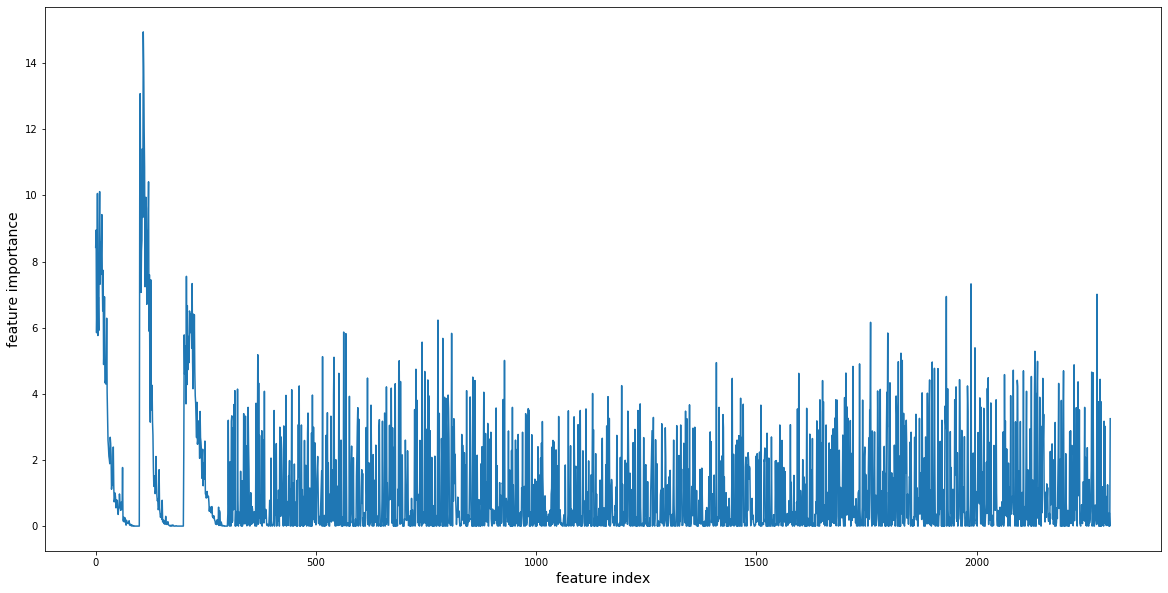

In [355]:
plt.figure(num=None, figsize=(20,10))
plt.plot(average_fis)
plt.xlabel('feature index', fontsize=14)
plt.ylabel('feature importance', fontsize=14)
plt.savefig('negishi_full_bm_fis.png', dpi=100)

In [356]:
plt.close()

## Adversarial controls

In [34]:
# View current training set
X_train

,0,1,2,3,4,5,6,7,8,9,...,product_NsssN,product_VSA_EState8,product_n9FARing,product_GGI6,product_Xch-4d,product_n7AHRing,product_n10ARing,product_PEOE_VSA13,product_n7HRing,product_SMR_VSA9
0,66.0,114.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,67.0,...,0,0.829308,0,0.100408,0.0,0,0,0.000000,0,11.387856
1,66.0,114.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,67.0,...,0,0.800962,0,0.222857,0.0,0,0,0.000000,0,22.775712
2,67.0,108.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,40.0,...,0,0.000000,0,0.160000,0.0,0,0,0.000000,0,17.196124
3,67.0,79.0,67.0,79.0,67.0,49.0,61.0,67.0,67.0,40.0,...,0,0.000000,0,0.503673,0.0,0,0,0.000000,0,11.499024
4,67.0,108.0,91.0,90.0,110.0,93.0,67.0,35.0,67.0,0.0,...,0,0.000000,0,0.060408,0.0,0,0,0.000000,0,12.343784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6237,70.0,83.0,40.0,61.0,79.0,41.0,40.0,61.0,79.0,41.0,...,0,0.000000,0,0.584535,0.0,0,0,5.559267,0,11.387856
6238,70.0,83.0,40.0,61.0,79.0,41.0,40.0,61.0,79.0,41.0,...,0,0.000000,0,0.164082,0.0,0,0,0.000000,0,0.000000
6239,67.0,67.0,67.0,67.0,67.0,92.0,67.0,40.0,67.0,41.0,...,0,0.000000,0,0.164082,0.0,0,0,0.000000,0,0.000000
6240,67.0,79.0,67.0,79.0,67.0,49.0,61.0,67.0,40.0,67.0,...,0,0.000000,0,0.204082,0.0,0,0,0.000000,0,0.000000


### Shuffle inputs, leaving outputs the same (shuffle inputs)
Trains model on fake reactions, testing on same test set of real ones

In [52]:
# Shuffle row ordering removing index
X_train_shuffle = np.random.permutation(X_train.copy().values)

# Create new dataframe with the shuffled rows, retaining original indices
X_train_shuffle_inputs = pd.DataFrame(
    X_train_shuffle, index=X_train.index, columns=X_train.columns
)

# View new dataframe (can see inputs have changed)
X_train_shuffle_inputs

,0,1,2,3,4,5,6,7,8,9,...,product_NsssN,product_VSA_EState8,product_n9FARing,product_GGI6,product_Xch-4d,product_n7AHRing,product_n10ARing,product_PEOE_VSA13,product_n7HRing,product_SMR_VSA9
0,67.0,108.0,67.0,49.0,61.0,67.0,40.0,73.0,41.0,67.0,...,0.0,0.000000,0.0,0.122449,0.0,0.0,0.0,0.000000,0.0,0.000000
1,67.0,67.0,49.0,61.0,67.0,67.0,40.0,70.0,41.0,61.0,...,0.0,13.449839,0.0,0.264490,0.0,0.0,0.0,0.000000,0.0,6.069221
2,67.0,79.0,67.0,40.0,61.0,79.0,41.0,67.0,49.0,61.0,...,1.0,13.945364,0.0,0.645714,0.0,0.0,0.0,0.000000,0.0,11.499024
3,73.0,92.0,67.0,61.0,67.0,92.0,67.0,49.0,61.0,67.0,...,0.0,1.883891,0.0,0.416417,0.0,0.0,0.0,0.000000,0.0,0.000000
4,66.0,114.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,67.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,11.840869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6237,66.0,114.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,92.0,...,0.0,7.201605,0.0,0.969796,0.0,0.0,0.0,8.317393,0.0,0.000000
6238,67.0,79.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,40.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
6239,67.0,67.0,79.0,67.0,40.0,61.0,79.0,41.0,67.0,49.0,...,0.0,0.000000,0.0,0.123265,0.0,0.0,0.0,0.000000,0.0,0.000000
6240,67.0,67.0,40.0,67.0,41.0,40.0,67.0,41.0,67.0,49.0,...,0.0,1.706004,0.0,0.587755,0.0,0.0,0.0,0.000000,0.0,21.828455


In [53]:
# But indices have stayed the same
X_train_shuffle_inputs.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,   10,
            ...
            6232, 6233, 6234, 6235, 6236, 6237, 6238, 6239, 6240, 6241],
           dtype='int64', length=5534)

In [44]:
X_train.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,   10,
            ...
            6232, 6233, 6234, 6235, 6236, 6237, 6238, 6239, 6240, 6241],
           dtype='int64', length=5534)

In [54]:
# Re-train and test model
start_time = time.time()
shuffle_inputs_file = 'shuffle_inputs_bm_gbm.model.joblib'
shuffle_inputs_bm_gbm = train_lgbm_classifier(
    X_train_shuffle_inputs, y_train, shuffle_inputs_file
)
print(f'Training complete. Training time: {time.time()-start_time} s')

# Make predictions with trained model
shuffle_inputs_bm_preds = shuffle_inputs_bm_gbm.predict_proba(X_test)

# Get top-k predicted rankings from prediction set
suffle_inputs_bm_preds_labeled = get_top_k_preds(
    shuffle_inputs_bm_preds, cutoffs, category_initials, k=3, 
    include_nulls=True
)

# Get labels from ground truth
y_test_labeled = label_ground_truth(
    y_test, cutoffs, category_initials, include_nulls=True
)

# Format results for performance metric calculations
type_count = get_type_count(cutoffs, category_initials)
shuffle_inputs_bm_formatted_results = format_results_for_metrics(
    suffle_inputs_bm_preds_labeled, y_test_labeled, type_count, 
    category_initials
)

# Calculate metrics and save results file
shuffle_inputs_bm_metrics = get_metrics_dict(
    shuffle_inputs_bm_formatted_results, type_count, 
    'shuffle_inputs_bm_metrics.json'
)

# View top-1 and top-3 accuracy metrics
shuffle_inputs_top_1_acc = shuffle_inputs_bm_metrics['top_1_acc']
shuffle_inputs_top_3_acc = shuffle_inputs_bm_metrics['top_k_acc']

/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 88 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 105 is present in all training examples.
  str(classes[c]))


Training complete. Training time: 2532.98215007782 s
Top 1 accuracy for type  M  : 0.2294022617124394
Top 3 accuracy for type  M  : 0.481421647819063
Top 1 accuracy for type  L  : 0.7738287560581584
Top 3 accuracy for type  L  : 0.8303715670436187
Top 1 accuracy for type  S  : 0.6865912762520194
Top 3 accuracy for type  S  : 0.8675282714054927
Top 1 accuracy for type  A  : 0.8319870759289176
Top 3 accuracy for type  A  : 0.8949919224555735
Top 1 accuracy for type  T  : 0.2924071082390953
Top 3 accuracy for type  T  : 0.5735056542810986
Top 1 accuracy for type  O  : 0.8190630048465266
Top 3 accuracy for type  O  : 1.0


### Feature importances

In [357]:
num_estimators = len(shuffle_inputs_bm_gbm.estimators_)
all_fis = []

for i in range(num_estimators):
    try:
        all_fis.append(
            shuffle_inputs_bm_gbm.estimators_[i].feature_importances_
        ) 
    except:
        continue
             
average_fis = np.average(np.array(all_fis), axis=0)
smiles_fis = average_fis[:300]
mordred_fis = average_fis[300:]

sorted_fis = np.argsort(-average_fis)
sorted_smiles_fis = np.argsort(-smiles_fis)
sorted_mordred_fis = np.argsort(-mordred_fis)

fi_names = X_train.columns[sorted_fis]
smiles_fi_names = X_train.columns[sorted_smiles_fis]
mordred_fi_names = X_train.columns[(sorted_mordred_fis+300)]

mordred_fi_df = pd.DataFrame(
    list(zip(mordred_fi_names, mordred_fis[sorted_mordred_fis])), 
    columns=['mordred_descriptor', 'fi_score']
)
mordred_fi_df.to_csv('negishi_shuffle_inputs_mordred_fis.csv')

top_fis = sorted_fis[:20]
top_smiles_fis = sorted_smiles_fis[:20]
top_mordred_fis = sorted_mordred_fis[:20]

top_fi_names = fi_names[:20]
top_smiles_fi_names = smiles_fi_names[:20]
top_mordred_fi_names = mordred_fi_names[:20]

print(top_fi_names)
print(top_smiles_fi_names)
print(top_mordred_fi_names)

Index(['13', '16', 'product_ATSC7i', 'rdfred_1_ATSC4p', '15', 'product_JGI6',
       '109', '220', 'product_JGI3', 'product_JGI4', '12', '11',
       'product_JGI5', 'product_JGI8', 'product_JGI7', 'product_ATSC4dv',
       'product_ATSC8i', '217', '216', '221'],
      dtype='object')
Index(['13', '16', '15', '109', '220', '12', '11', '217', '221', '216', '10',
       '8', '224', '9', '225', '106', '218', '226', '223', '18'],
      dtype='object')
Index(['product_ATSC7i', 'rdfred_1_ATSC4p', 'product_JGI6', 'product_JGI3',
       'product_JGI4', 'product_JGI5', 'product_JGI8', 'product_JGI7',
       'product_ATSC4dv', 'product_ATSC8i', 'product_JGI9',
       'rdfred_1_EState_VSA6', 'product_EState_VSA7', 'product_EState_VSA4',
       'product_ATSC5i', 'product_ATSC6se', 'product_ATSC1se', 'product_JGI2',
       'product_ATSC7se', 'product_ATSC6dv'],
      dtype='object')


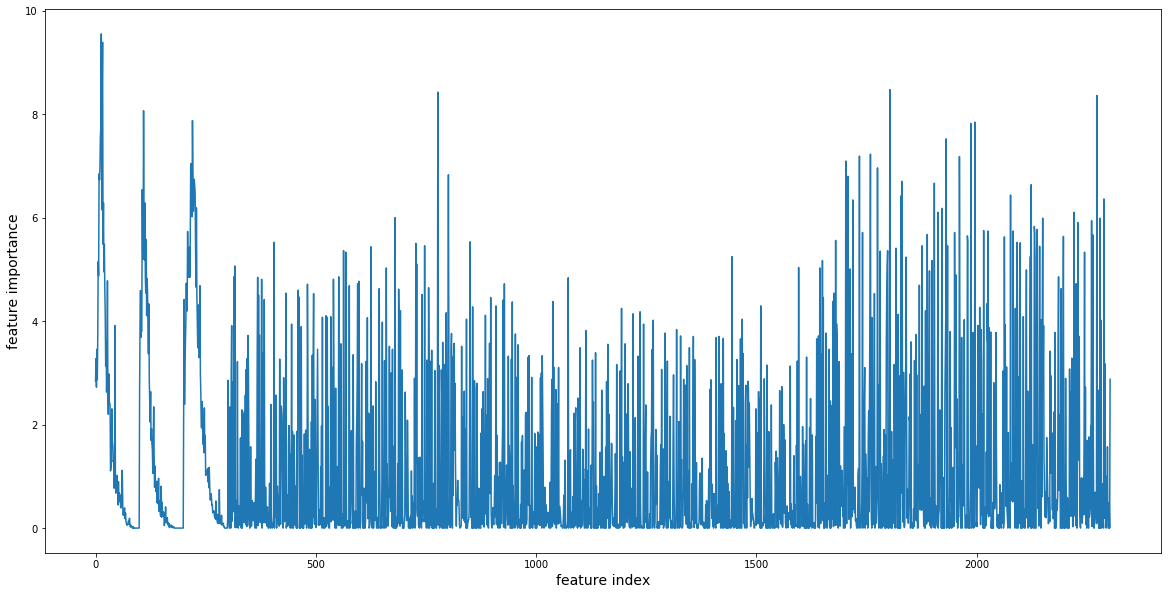

In [358]:
plt.figure(num=None, figsize=(20,10))
plt.plot(average_fis)
plt.xlabel('feature index', fontsize=14)
plt.ylabel('feature importance', fontsize=14)
plt.savefig('negishi_shuffle_inputs_bm_fis.png', dpi=100)

In [359]:
plt.close()

### Ablate SMILES region (Mordred only)

In [63]:
# Create new dataframe from only the Mordred input region
X_train_mordred = X_train[X_train.columns[300:]].copy()
X_test_mordred = X_test[X_test.columns[300:]].copy()
print(X_test_mordred.shape)

# View new dataframe (can see inputs have changed)
X_train_mordred

(619, 2004)


,rdfred_1_Diameter,rdfred_1_ATSC1m,rdfred_1_piPC3,rdfred_1_n5aHRing,rdfred_1_n4AHRing,rdfred_1_EState_VSA3,rdfred_1_ATS0i,rdfred_1_SaaSe,rdfred_1_CIC3,rdfred_1_ATSC1p,...,product_NsssN,product_VSA_EState8,product_n9FARing,product_GGI6,product_Xch-4d,product_n7AHRing,product_n10ARing,product_PEOE_VSA13,product_n7HRing,product_SMR_VSA9
0,4,-1.901154e+01,3.409496,0,0,0.000000,1679.096540,0.0,-4.440892e-16,-4.247127e-02,...,0,0.829308,0,0.100408,0.0,0,0,0.000000,0,11.387856
1,7,-1.121152e+00,4.226834,0,0,0.000000,3079.061340,0.0,1.000000e+00,-2.023735e-01,...,0,0.800962,0,0.222857,0.0,0,0,0.000000,0,22.775712
2,6,-4.796163e-14,3.669951,0,0,10.586085,2006.630591,0.0,-4.440892e-16,1.304512e-15,...,0,0.000000,0,0.160000,0.0,0,0,0.000000,0,17.196124
3,10,4.178395e+01,3.956040,0,0,11.499024,5049.873711,0.0,1.105312e+00,-1.919692e+00,...,0,0.000000,0,0.503673,0.0,0,0,0.000000,0,11.499024
4,3,3.753147e+02,1.386294,0,0,0.000000,694.916767,0.0,0.000000e+00,-1.360626e+00,...,0,0.000000,0,0.060408,0.0,0,0,0.000000,0,12.343784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6237,11,-4.464207e+01,5.102911,1,0,21.880439,4819.865338,0.0,6.451613e-02,5.450789e-01,...,0,0.000000,0,0.584535,0.0,0,0,5.559267,0,11.387856
6238,8,-4.366625e+00,2.197225,0,0,0.000000,3897.348465,0.0,7.814536e-01,-2.243643e-01,...,0,0.000000,0,0.164082,0.0,0,0,0.000000,0,0.000000
6239,8,-4.366625e+00,2.197225,0,0,0.000000,3897.348465,0.0,7.814536e-01,-2.243643e-01,...,0,0.000000,0,0.164082,0.0,0,0,0.000000,0,0.000000
6240,10,-4.058288e+01,2.890372,0,0,0.000000,5202.853427,0.0,4.846805e-01,1.721917e-01,...,0,0.000000,0,0.204082,0.0,0,0,0.000000,0,0.000000


In [65]:
# Re-train and test model
start_time = time.time()
mordred_only_file = 'mordred_only_bm_gbm.model.joblib'
mordred_only_bm_gbm = train_lgbm_classifier(X_train_mordred, y_train, mordred_only_file)
print(f'Training complete. Training time: {time.time()-start_time} s')

# Make predictions with trained model
mordred_only_preds = mordred_only_bm_gbm.predict_proba(X_test_mordred)

# Get top-k predicted rankings from prediction set
mordred_only_preds_labeled = get_top_k_preds(
    mordred_only_preds, cutoffs, category_initials, k=3, include_nulls=True
)

# Get labels from ground truth
y_test_labeled = label_ground_truth(y_test, cutoffs, category_initials,
                                    include_nulls=True)

# Format results for performance metric calculations
type_count = get_type_count(cutoffs, category_initials)
mordred_only_formatted_results = format_results_for_metrics(
    mordred_only_preds_labeled, y_test_labeled, type_count, category_initials
)

# Calculate metrics and save results file
mordred_only_metrics = get_metrics_dict(
    mordred_only_formatted_results, type_count, 'mordred_only_metrics.json'
)

# View top-1 and top-3 accuracy metrics
mordred_only_top_1_acc = mordred_only_metrics['top_1_acc']
mordred_only_top_3_acc = mordred_only_metrics['top_k_acc']

/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 88 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 105 is present in all training examples.
  str(classes[c]))


Training complete. Training time: 701.3166437149048 s
Top 1 accuracy for type  M  : 0.42487883683360256
Top 3 accuracy for type  M  : 0.6736672051696284
Top 1 accuracy for type  L  : 0.7835218093699515
Top 3 accuracy for type  L  : 0.9079159935379645
Top 1 accuracy for type  S  : 0.7382875605815832
Top 3 accuracy for type  S  : 0.8933764135702746
Top 1 accuracy for type  A  : 0.8336025848142165
Top 3 accuracy for type  A  : 0.9240710823909531
Top 1 accuracy for type  T  : 0.6203554119547657
Top 3 accuracy for type  T  : 0.864297253634895
Top 1 accuracy for type  O  : 0.8255250403877221
Top 3 accuracy for type  O  : 1.0


### Feature importances

In [360]:
num_estimators = len(mordred_only_bm_gbm.estimators_)
all_fis = []

for i in range(num_estimators):
    try:
        all_fis.append(mordred_only_bm_gbm.estimators_[i].feature_importances_) 
    except:
        continue
             
average_fis = np.average(np.array(all_fis), axis=0)
sorted_fis = np.argsort(-average_fis)
mordred_fi_names = X_train_mordred.columns[sorted_fis]

mordred_fi_df = pd.DataFrame(
    list(zip(mordred_fi_names, average_fis[sorted_fis])), 
    columns=['mordred_descriptor', 'fi_score']
)
mordred_fi_df.to_csv('negishi_mordred_only_fis.csv')

top_fis = sorted_fis[:20]

top_fi_names = X_train_mordred.columns[top_fis]

print(top_fi_names)

Index(['product_JGI6', 'product_JGI4', 'rdfred_1_AATSC0i', 'product_JGI3',
       'product_JGI5', 'product_ATSC8i', 'product_JGI7', 'product_ATSC3i',
       'product_ATSC4i', 'product_ATSC8d', 'product_JGI2', 'product_ATSC7i',
       'product_ATSC2dv', 'product_JGI8', 'product_ATSC6i',
       'product_PEOE_VSA7', 'product_fMF', 'product_SaasC', 'product_ATSC4d',
       'product_ATSC3v'],
      dtype='object')


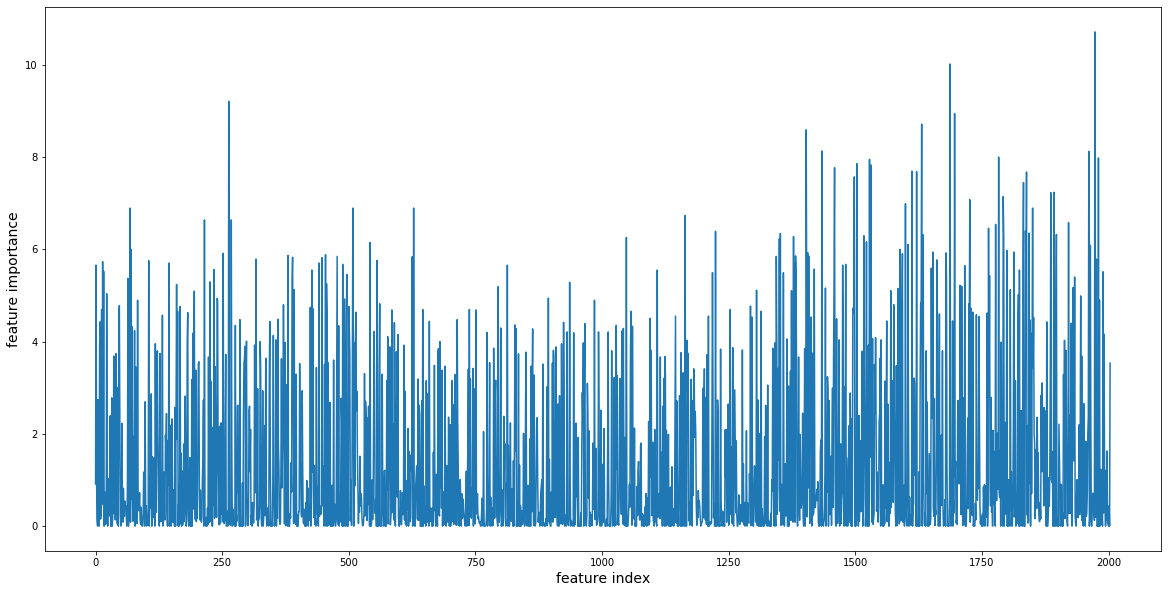

In [361]:
plt.figure(num=None, figsize=(20,10))
plt.plot(average_fis)
plt.xlabel('feature index', fontsize=14)
plt.ylabel('feature importance', fontsize=14)
plt.savefig('negishi_mordred_only_bm_fis.png', dpi=100)

In [362]:
plt.close()

## Feature selection

In [297]:
# Choose top-100 FIs to re-train slim model
selected_features = np.argsort(-average_fis)[:100]
selected_columns = X_train_mordred.columns[selected_features]
X_train_mordred_feat_sel = X_train_mordred[list(selected_columns)]
X_test_mordred_feat_sel = X_test_mordred[list(selected_columns)]
X_train_mordred_feat_sel

,product_JGI6,product_JGI4,rdfred_1_AATSC0i,product_JGI3,product_JGI5,product_ATSC8i,product_JGI7,product_ATSC3i,product_ATSC4i,product_ATSC8d,...,rdfred_1_CIC2,product_ATSC7se,product_ATSC2se,rdfred_2_EState_VSA5,rdfred_1_ATSC4d,product_AATS0d,product_CIC1,product_ATSC4se,product_SdssC,rdfred_1_SaaaC
0,0.016735,0.027778,1.447870,0.035156,0.025000,0.614398,0.013889,7.846089,-0.676019,1.875000,...,0.432263,-0.030199,0.115145,4.288268,-0.330579,3.550000,1.958063,-0.297050,0.000000,0.000000
1,0.012381,0.024155,1.567056,0.030093,0.025253,-0.140444,0.006944,14.007380,-0.340802,-0.173603,...,1.475489,-0.028727,0.116325,4.288268,-4.800000,3.724138,2.431155,-0.486940,0.000000,0.000000
2,0.022857,0.022564,1.515089,0.024306,0.031250,1.327720,0.009375,-9.459554,-8.016145,0.274102,...,0.615385,0.084828,-0.033240,4.157791,0.668639,3.347826,2.567767,-0.081803,0.000000,0.000000
3,0.020147,0.035986,1.259963,0.056250,0.021759,-9.930705,0.009320,-15.136801,0.183983,-3.068357,...,1.234344,-1.173559,0.141721,23.774711,-3.628512,2.680851,2.928697,0.686495,0.000000,0.000000
4,0.008630,0.016790,2.182858,0.015625,0.011285,-1.755162,0.007234,-2.368486,3.815916,-0.787158,...,0.000000,0.031792,0.245792,12.841643,0.160000,2.413793,2.029676,-0.769451,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6237,0.022482,0.045725,1.597449,0.046181,0.033908,5.134420,0.012011,-15.655241,-22.635683,-5.077429,...,0.762951,0.169504,0.656106,10.030323,-3.243496,3.837838,1.592233,0.746863,0.000000,2.746064
6238,0.010939,0.026901,1.405968,0.038690,0.022059,-2.377117,0.010283,-5.851714,-4.196385,-1.434819,...,1.364787,0.000711,-0.049338,11.984273,-0.208333,2.285714,3.176889,-0.018204,0.000000,0.000000
6239,0.010939,0.026901,1.405968,0.038690,0.022059,-2.377117,0.010283,-5.851714,-4.196385,-1.434819,...,1.364787,0.000711,-0.049338,15.743067,-0.208333,2.285714,3.176889,-0.018204,0.000000,0.000000
6240,0.020408,0.026667,1.376133,0.038462,0.015152,-13.173668,0.006250,-7.770728,0.591765,2.222222,...,0.945771,0.120589,-0.022689,0.000000,-0.745117,2.102564,2.538375,0.068189,0.000000,0.000000


In [298]:
X_test_mordred_feat_sel

,product_JGI6,product_JGI4,rdfred_1_AATSC0i,product_JGI3,product_JGI5,product_ATSC8i,product_JGI7,product_ATSC3i,product_ATSC4i,product_ATSC8d,...,rdfred_1_CIC2,product_ATSC7se,product_ATSC2se,rdfred_2_EState_VSA5,rdfred_1_ATSC4d,product_AATS0d,product_CIC1,product_ATSC4se,product_SdssC,rdfred_1_SaaaC
9,0.034985,0.052667,1.393156,0.071023,0.050214,14.308021,0.000000,-27.110479,-1.671504,5.555556,...,1.463042,-0.864576,1.088404,0.000000,-1.597633,3.185185,1.584963,0.155472,0.000000,0.000000
21,0.019416,0.037449,1.496430,0.043527,0.026730,-35.190204,0.011636,-24.731498,1.113325,11.197500,...,1.240021,0.382254,0.306126,0.000000,3.286125,3.350000,2.206027,-0.689626,-0.238371,1.681000
25,0.012245,0.042614,1.309516,0.043750,0.028241,4.996002,0.014236,-11.456959,-2.558544,2.479167,...,1.337169,-0.274673,-0.000383,0.000000,-4.446125,3.458333,2.083333,0.073480,0.000000,0.000000
27,0.012245,0.042614,1.309516,0.043750,0.028241,4.996002,0.014236,-11.456959,-2.558544,2.479167,...,1.337169,-0.274673,-0.000383,0.000000,-4.446125,3.458333,2.083333,0.073480,0.000000,0.000000
32,0.020204,0.046222,1.389759,0.062500,0.036265,5.528904,0.000000,-2.467043,-9.059996,1.564815,...,0.279699,0.092674,-0.193183,0.000000,-5.131488,3.611111,0.375272,-0.536255,-0.579722,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6213,0.012658,0.055116,2.006193,0.063272,0.058733,223.825505,0.021617,-47.617728,76.858281,43.026786,...,0.200000,-1.400086,0.937286,14.697085,0.140000,2.892857,3.076005,0.537302,0.000000,0.000000
6224,0.012514,0.028788,1.526320,0.021635,0.035139,7.326965,0.005148,-16.481098,-13.289890,-3.071289,...,0.797180,0.005124,-0.051951,0.000000,-1.726562,3.468750,2.203234,-0.876308,0.000000,0.000000
6226,0.014355,0.026264,4.094199,0.031250,0.018633,-6.144058,0.007270,-11.451323,-18.385812,-6.294983,...,1.326450,-0.205634,0.386071,0.000000,-5.800000,3.735294,2.915449,-0.232906,0.000000,0.889074
6228,0.013794,0.034511,1.415317,0.040972,0.016548,-13.662691,0.005831,-7.956085,-6.250499,-2.277778,...,1.620070,-0.148873,0.436451,0.000000,-5.197531,3.900000,2.695413,-0.443971,0.000000,2.662037


In [299]:
# Re-train and test model
start_time = time.time()
mordred_feat_sel_file = 'mordred_feat_sel_bm_gbm.model.joblib'
mordred_feat_sel_bm_gbm = train_lgbm_classifier(
    X_train_mordred_feat_sel, y_train, mordred_feat_sel_file
)
print(f'Training complete. Training time: {time.time()-start_time} s')

# Make predictions with trained model
mordred_feat_sel_preds = mordred_feat_sel_bm_gbm.predict_proba(
    X_test_mordred_feat_sel
)

# Get top-k predicted rankings from prediction set
mordred_feat_sel_preds_labeled = get_top_k_preds(
    mordred_feat_sel_preds, cutoffs, category_initials, k=3, include_nulls=True
)

# Get labels from ground truth
y_test_labeled = label_ground_truth(y_test, cutoffs, category_initials,
                                    include_nulls=True)

# Format results for performance metric calculations
type_count = get_type_count(cutoffs, category_initials)
mordred_feat_sel_formatted_results = format_results_for_metrics(
    mordred_feat_sel_preds_labeled, y_test_labeled, type_count, 
    category_initials
)

# Calculate metrics and save results file
mordred_feat_sel_metrics = get_metrics_dict(
    mordred_feat_sel_formatted_results, type_count, 
    'mordred_feat_sel_metrics.json'
)

# View top-1 and top-3 accuracy metrics
mordred_feat_sel_top_1_acc = mordred_feat_sel_metrics['top_1_acc']
mordred_feat_sel_top_3_acc = mordred_feat_sel_metrics['top_k_acc']

/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 88 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 105 is present in all training examples.
  str(classes[c]))


Training complete. Training time: 72.12132692337036 s
Top 1 accuracy for type  M  : 0.4184168012924071
Top 3 accuracy for type  M  : 0.6348949919224556
Top 1 accuracy for type  L  : 0.777059773828756
Top 3 accuracy for type  L  : 0.901453957996769
Top 1 accuracy for type  S  : 0.7269789983844911
Top 3 accuracy for type  S  : 0.8966074313408724
Top 1 accuracy for type  A  : 0.8384491114701131
Top 3 accuracy for type  A  : 0.9240710823909531
Top 1 accuracy for type  T  : 0.6025848142164781
Top 3 accuracy for type  T  : 0.840064620355412
Top 1 accuracy for type  O  : 0.8190630048465266
Top 3 accuracy for type  O  : 1.0


### Feature importances

In [371]:
num_estimators = len(mordred_feat_sel_bm_gbm.estimators_)
all_fis = []

for i in range(num_estimators):
    try:
        all_fis.append(mordred_feat_sel_bm_gbm.estimators_[i].feature_importances_) 
    except:
        continue
             
average_fis = np.average(np.array(all_fis), axis=0)
sorted_fis = np.argsort(-average_fis)
mordred_fi_names = X_train_mordred_feat_sel.columns[sorted_fis]

mordred_fi_df = pd.DataFrame(
    list(zip(mordred_fi_names, average_fis[sorted_fis])), 
    columns=['mordred_descriptor', 'fi_score']
)
mordred_fi_df.to_csv('negishi_mordred_feat_sel_bm_fis.csv')

top_fis = sorted_fis[:20]

top_fi_names = X_train_mordred_feat_sel.columns[top_fis]

print(top_fi_names)

Index(['rdfred_1_ATS0Z', 'rdfred_2_ATSC1se', 'rdfred_2_ATSC1i',
       'rdfred_2_ATSC3p', 'rdfred_2_ATSC4d', 'rdfred_1_ZMIC2', 'product_MIC1',
       'product_JGI3', 'product_JGI5', 'product_JGI4', 'rdfred_2_ATSC3v',
       'rdfred_1_AATSC0i', 'product_JGI6', 'rdfred_1_MIC1', 'rdfred_1_ATSC1se',
       'rdfred_1_IC0', 'rdfred_1_ATSC1m', 'product_ATSC2dv', 'product_AATSC0i',
       'product_ATSC2se'],
      dtype='object')


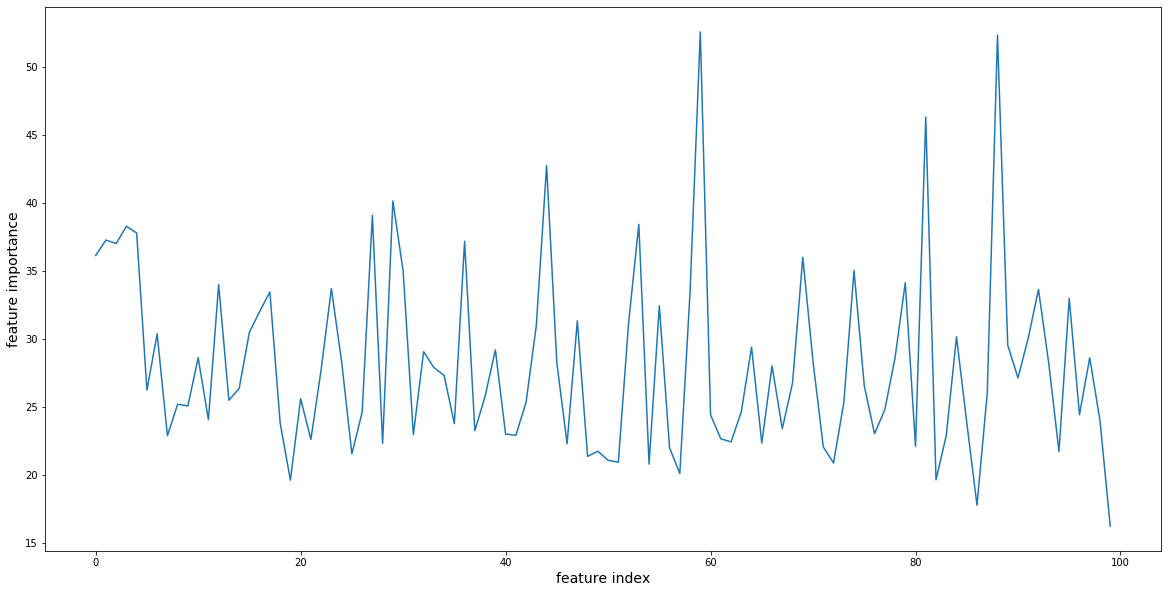

In [372]:
plt.figure(num=None, figsize=(20,10))
plt.plot(average_fis)
plt.xlabel('feature index', fontsize=14)
plt.ylabel('feature importance', fontsize=14)
plt.savefig('negishi_mordred_feat_sel_bm_fis.png', dpi=100)

In [373]:
plt.close()

### Ablate Mordred region (SMILES only)

In [66]:
# Create new dataframe from only the Mordred input region
X_train_smiles = X_train[X_train.columns[:300]].copy()
X_test_smiles = X_test[X_test.columns[:300]].copy()
print(X_test_smiles.shape)

# View new dataframe (can see inputs have changed)
X_train_smiles

(619, 300)


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,66.0,114.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,66.0,114.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,67.0,108.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,67.0,79.0,67.0,79.0,67.0,49.0,61.0,67.0,67.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,67.0,108.0,91.0,90.0,110.0,93.0,67.0,35.0,67.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6237,70.0,83.0,40.0,61.0,79.0,41.0,40.0,61.0,79.0,41.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6238,70.0,83.0,40.0,61.0,79.0,41.0,40.0,61.0,79.0,41.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6239,67.0,67.0,67.0,67.0,67.0,92.0,67.0,40.0,67.0,41.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6240,67.0,79.0,67.0,79.0,67.0,49.0,61.0,67.0,40.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
# Re-train and test model
start_time = time.time()
smiles_only_file = 'smiles_only_bm_gbm.model.joblib'
smiles_only_bm_gbm = train_lgbm_classifier(X_train_smiles, y_train, smiles_only_file)
print(f'Training complete. Training time: {time.time()-start_time} s')

# Make predictions with trained model
smiles_only_preds = smiles_only_bm_gbm.predict_proba(X_test_smiles)

# Get top-k predicted rankings from prediction set
smiles_only_preds_labeled = get_top_k_preds(
    smiles_only_preds, cutoffs, category_initials, k=3, include_nulls=True
)

# Get labels from ground truth
y_test_labeled = label_ground_truth(y_test, cutoffs, category_initials,
                                    include_nulls=True)

# Format results for performance metric calculations
type_count = get_type_count(cutoffs, category_initials)
smiles_only_formatted_results = format_results_for_metrics(
    smiles_only_preds_labeled, y_test_labeled, type_count, category_initials
)

# Calculate metrics and save results file
smiles_only_metrics = get_metrics_dict(
    smiles_only_formatted_results, type_count, 'smiles_only_metrics.json'
)

# View top-1 and top-3 accuracy metrics
smiles_only_top_1_acc = smiles_only_metrics['top_1_acc']
smiles_only_top_3_acc = smiles_only_metrics['top_k_acc']

/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 88 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 105 is present in all training examples.
  str(classes[c]))


Training complete. Training time: 33.12547016143799 s
Top 1 accuracy for type  M  : 0.6284329563812601
Top 3 accuracy for type  M  : 0.8045234248788369
Top 1 accuracy for type  L  : 0.8319870759289176
Top 3 accuracy for type  L  : 0.9450726978998385
Top 1 accuracy for type  S  : 0.8723747980613893
Top 3 accuracy for type  S  : 0.9434571890145396
Top 1 accuracy for type  A  : 0.8594507269789984
Top 3 accuracy for type  A  : 0.9547657512116317
Top 1 accuracy for type  T  : 0.5654281098546042
Top 3 accuracy for type  T  : 0.8497576736672051
Top 1 accuracy for type  O  : 0.8352180936995154
Top 3 accuracy for type  O  : 1.0


### Feature importances

In [366]:
num_estimators = len(smiles_only_bm_gbm.estimators_)
all_fis = []

for i in range(num_estimators):
    try:
        all_fis.append(smiles_only_bm_gbm.estimators_[i].feature_importances_) 
    except:
        continue
             
average_fis = np.average(np.array(all_fis), axis=0)

top_fis = np.argsort(-average_fis)[:20]

top_fi_names = X_train_smiles.columns[top_fis]

print(top_fi_names)

Index(['11', '9', '109', '14', '16', '12', '108', '15', '10', '115', '8', '13',
       '110', '106', '17', '114', '113', '222', '111', '216'],
      dtype='object')


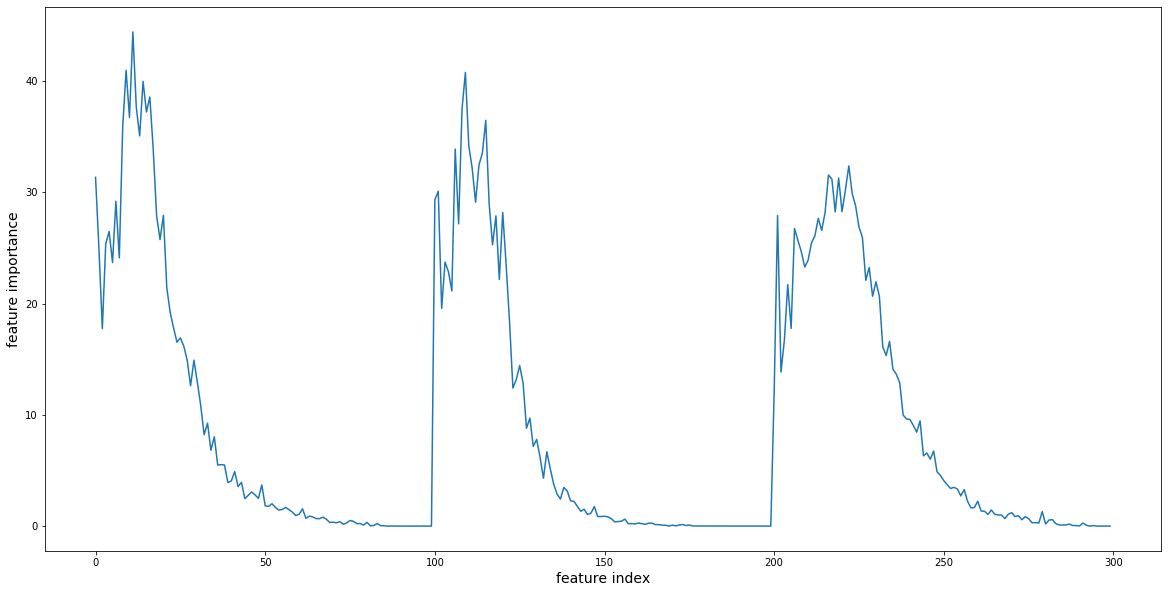

In [367]:
plt.figure(num=None, figsize=(20,10))
plt.plot(average_fis)
plt.xlabel('feature index', fontsize=14)
plt.ylabel('feature importance', fontsize=14)
plt.savefig('negishi_smiles_only_bm_fis.png', dpi=100)

In [368]:
plt.close()

### Shuffle SMILES vectors, leaving outputs the same (shuffle SMILES)
Trains model on fake reactions, testing on same test set of real ones

In [330]:
# Show SMILES dataset for comparison
X_train_smiles

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,66.0,114.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,66.0,114.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,67.0,108.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,67.0,79.0,67.0,79.0,67.0,49.0,61.0,67.0,67.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,67.0,108.0,91.0,90.0,110.0,93.0,67.0,35.0,67.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6237,70.0,83.0,40.0,61.0,79.0,41.0,40.0,61.0,79.0,41.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6238,70.0,83.0,40.0,61.0,79.0,41.0,40.0,61.0,79.0,41.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6239,67.0,67.0,67.0,67.0,67.0,92.0,67.0,40.0,67.0,41.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6240,67.0,79.0,67.0,79.0,67.0,49.0,61.0,67.0,40.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [331]:
# Shuffle row ordering removing index
X_train_smiles_shuffle = np.random.permutation(X_train_smiles.copy().values)

# Create new dataframe with the shuffled rows, retaining original indices
X_train_smiles_shuffle_inputs = pd.DataFrame(
    X_train_smiles_shuffle, index=X_train_smiles.index, 
    columns=X_train_smiles.columns
)

# View new dataframe (can see inputs have changed)
X_train_smiles_shuffle_inputs

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,66.0,114.0,91.0,90.0,110.0,93.0,67.0,61.0,67.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,67.0,67.0,40.0,67.0,41.0,40.0,67.0,41.0,67.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,73.0,91.0,90.0,110.0,93.0,67.0,49.0,61.0,67.0,50.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,67.0,67.0,40.0,67.0,41.0,40.0,67.0,41.0,79.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,67.0,108.0,67.0,49.0,61.0,78.0,67.0,61.0,67.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6237,73.0,67.0,49.0,61.0,67.0,40.0,78.0,40.0,78.0,61.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6238,67.0,79.0,67.0,40.0,61.0,79.0,41.0,67.0,49.0,61.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6239,78.0,67.0,49.0,61.0,67.0,40.0,67.0,108.0,41.0,78.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6240,73.0,91.0,90.0,110.0,93.0,67.0,49.0,67.0,67.0,79.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [332]:
# But indices have stayed the same
X_train_smiles_shuffle_inputs.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,   10,
            ...
            6232, 6233, 6234, 6235, 6236, 6237, 6238, 6239, 6240, 6241],
           dtype='int64', length=5534)

In [333]:
X_train_smiles.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,   10,
            ...
            6232, 6233, 6234, 6235, 6236, 6237, 6238, 6239, 6240, 6241],
           dtype='int64', length=5534)

In [334]:
# Check test set
X_test_smiles

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
9,67.0,67.0,40.0,67.0,41.0,40.0,67.0,41.0,67.0,49.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,67.0,67.0,40.0,67.0,41.0,67.0,91.0,67.0,64.0,64.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25,79.0,67.0,49.0,61.0,67.0,67.0,40.0,66.0,114.0,41.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,79.0,67.0,49.0,61.0,67.0,67.0,40.0,66.0,114.0,41.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32,67.0,79.0,67.0,40.0,61.0,79.0,41.0,67.0,49.0,61.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6213,67.0,108.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6224,79.0,67.0,40.0,61.0,79.0,41.0,92.0,67.0,61.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6226,79.0,67.0,40.0,61.0,79.0,41.0,92.0,67.0,61.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6228,79.0,67.0,92.0,67.0,61.0,67.0,40.0,47.0,73.0,41.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [335]:
# Re-train and test model
start_time = time.time()
shuffle_smiles_file = 'shuffle_smiles_bm_gbm.model.joblib'
shuffle_smiles_bm_gbm = train_lgbm_classifier(
    X_train_smiles_shuffle_inputs, y_train, shuffle_smiles_file
)
print(f'Training complete. Training time: {time.time()-start_time} s')

# Make predictions with trained model
shuffle_smiles_bm_preds = shuffle_smiles_bm_gbm.predict_proba(X_test_smiles)

# Get top-k predicted rankings from prediction set
shuffle_smiles_bm_preds_labeled = get_top_k_preds(
    shuffle_smiles_bm_preds, cutoffs, category_initials, k=3, 
    include_nulls=True
)

# Get labels from ground truth
y_test_labeled = label_ground_truth(
    y_test, cutoffs, category_initials, include_nulls=True
)

# Format results for performance metric calculations
type_count = get_type_count(cutoffs, category_initials)
shuffle_smiles_bm_formatted_results = format_results_for_metrics(
    shuffle_smiles_bm_preds_labeled, y_test_labeled, type_count, 
    category_initials
)

# Calculate metrics and save results file
shuffle_smiles_bm_metrics = get_metrics_dict(
    shuffle_smiles_bm_formatted_results, type_count, 
    'shuffle_smiles_bm_metrics.json'
)

# View top-1 and top-3 accuracy metrics
shuffle_smiles_top_1_acc = shuffle_smiles_bm_metrics['top_1_acc']
shuffle_smiles_top_3_acc = shuffle_smiles_bm_metrics['top_k_acc']

/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 88 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 105 is present in all training examples.
  str(classes[c]))


Training complete. Training time: 108.31762099266052 s
Top 1 accuracy for type  M  : 0.20678513731825526
Top 3 accuracy for type  M  : 0.43295638126009695
Top 1 accuracy for type  L  : 0.7576736672051696
Top 3 accuracy for type  L  : 0.8449111470113085
Top 1 accuracy for type  S  : 0.6736672051696284
Top 3 accuracy for type  S  : 0.8659127625201939
Top 1 accuracy for type  A  : 0.8109854604200323
Top 3 accuracy for type  A  : 0.8982229402261712
Top 1 accuracy for type  T  : 0.2762520193861066
Top 3 accuracy for type  T  : 0.5573505654281099
Top 1 accuracy for type  O  : 0.815831987075929
Top 3 accuracy for type  O  : 1.0


In [351]:
# View top-1 and top-3 accuracy metrics
shuffle_smiles_bm_metrics['top_1_acc']

{'M': 0.20678513731825526,
 'L': 0.7576736672051696,
 'S': 0.6736672051696284,
 'A': 0.8109854604200323,
 'T': 0.2762520193861066,
 'O': 0.815831987075929}

In [352]:
shuffle_smiles_bm_metrics['top_k_acc']

{'M': 0.43295638126009695,
 'L': 0.8449111470113085,
 'S': 0.8659127625201939,
 'A': 0.8982229402261712,
 'T': 0.5573505654281099,
 'O': 1.0}

### Feature importances

In [374]:
num_estimators = len(shuffle_smiles_bm_gbm.estimators_)
all_fis = []

for i in range(num_estimators):
    try:
        all_fis.append(
            shuffle_smiles_bm_gbm.estimators_[i].feature_importances_
        ) 
    except:
        continue
             
average_fis = np.average(np.array(all_fis), axis=0)

top_fis = np.argsort(-average_fis)[:20]

top_fi_names = X_train_smiles_shuffle_inputs.columns[top_fis]

print(top_fi_names)

Index(['11', '220', '13', '15', '9', '222', '10', '216', '219', '14', '224',
       '218', '109', '223', '12', '201', '16', '213', '217', '225'],
      dtype='object')


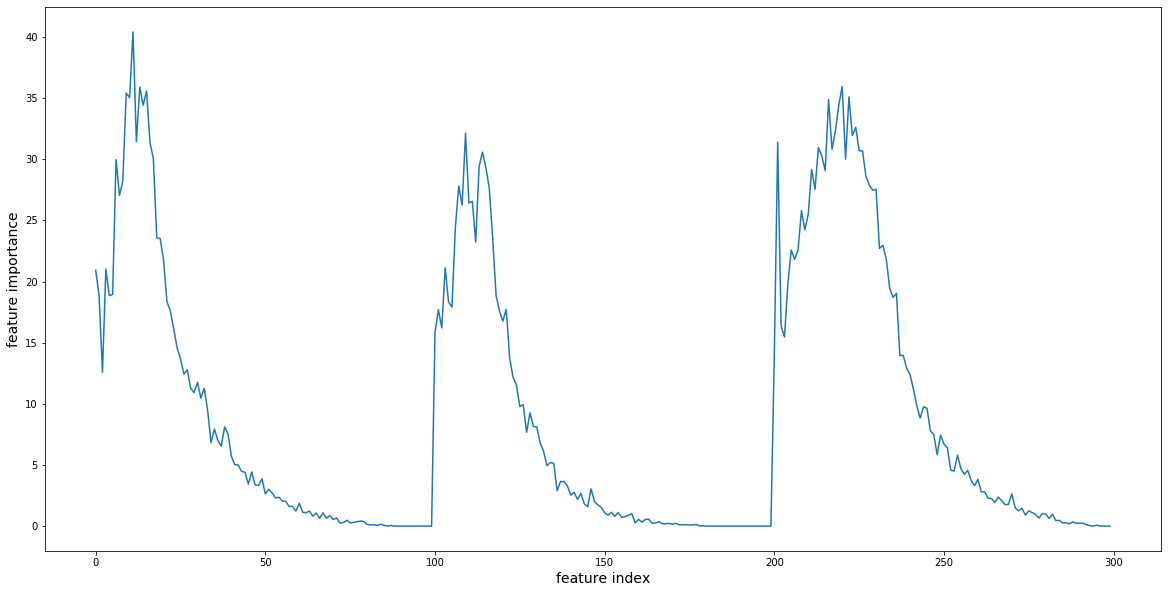

In [375]:
plt.figure(num=None, figsize=(20,10))
plt.plot(average_fis)
plt.xlabel('feature index', fontsize=14)
plt.ylabel('feature importance', fontsize=14)
plt.savefig('negishi_shuffle_smiles_bm_fis.png', dpi=100)

In [376]:
plt.close()

### Randomized SMILES representations (random SMILES) (SMILES barcode)
A random "barcode" is written for each unique molecule's SMILES drawing from a standard normal distribution. Essentially removes any continuity between chemical space, only identifying the unique molecules in a reaction.

In [202]:
# Get all unique tokenized SMILES from dataset
# Separate molecules
reactant_1_smiles = pd.DataFrame(
    X_full[X_full.columns[:100]].copy().values, index=X_full.index.values
)
reactant_2_smiles = pd.DataFrame(
    X_full[X_full.columns[100:200]].copy().values, index=X_full.index.values
)
product_smiles = pd.DataFrame(
    X_full[X_full.columns[200:300]].copy().values, index=X_full.index.values
)

# Join tabulated SMILES to single lists
for df in [reactant_1_smiles, reactant_2_smiles, product_smiles]:
    df['joined'] = df.values.tolist()
    df['str_joined'] = df['joined'].astype('str')

# Create dataframe with all unique SMILES from the dataset
unique_smiles = pd.concat(
    [reactant_1_smiles, reactant_2_smiles, product_smiles], ignore_index=True
)
print(f'Total SMILES: {len(unique_smiles)}')
unique_smiles = unique_smiles.drop_duplicates(subset=['str_joined'])
print(f'Unique SMILES: {len(unique_smiles)}')

# Create random fake SMILES representations for all unique molecules
unique_smiles['random'] = [
    np.random.randint(115, size=100).tolist() for _ in range(len(unique_smiles))
]
unique_smiles['str_random'] = unique_smiles['random'].astype('str')
unique_smiles

Total SMILES: 18459
Unique SMILES: 8984


,0,1,2,3,4,5,6,7,8,9,...,94,95,96,97,98,99,joined,str_joined,random,str_random
0,66.0,114.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[66.0, 114.0, 67.0, 49.0, 61.0, 67.0, 67.0, 61...","[66.0, 114.0, 67.0, 49.0, 61.0, 67.0, 67.0, 61...","[68, 100, 35, 66, 83, 8, 92, 71, 1, 27, 36, 29...","[68, 100, 35, 66, 83, 8, 92, 71, 1, 27, 36, 29..."
1,66.0,114.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[66.0, 114.0, 67.0, 49.0, 61.0, 67.0, 67.0, 61...","[66.0, 114.0, 67.0, 49.0, 61.0, 67.0, 67.0, 61...","[89, 100, 71, 105, 18, 31, 41, 1, 67, 27, 63, ...","[89, 100, 71, 105, 18, 31, 41, 1, 67, 27, 63, ..."
2,67.0,108.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 108.0, 67.0, 49.0, 61.0, 67.0, 67.0, 61...","[67.0, 108.0, 67.0, 49.0, 61.0, 67.0, 67.0, 61...","[42, 99, 5, 31, 14, 104, 52, 7, 60, 56, 33, 10...","[42, 99, 5, 31, 14, 104, 52, 7, 60, 56, 33, 10..."
3,67.0,79.0,67.0,79.0,67.0,49.0,61.0,67.0,67.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 79.0, 67.0, 79.0, 67.0, 49.0, 61.0, 67....","[67.0, 79.0, 67.0, 79.0, 67.0, 49.0, 61.0, 67....","[26, 36, 76, 59, 53, 67, 55, 28, 55, 19, 32, 1...","[26, 36, 76, 59, 53, 67, 55, 28, 55, 19, 32, 1..."
4,67.0,108.0,91.0,90.0,110.0,93.0,67.0,35.0,67.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 108.0, 91.0, 90.0, 110.0, 93.0, 67.0, 3...","[67.0, 108.0, 91.0, 90.0, 110.0, 93.0, 67.0, 3...","[79, 92, 71, 15, 23, 21, 4, 58, 113, 39, 95, 8...","[79, 92, 71, 15, 23, 21, 4, 58, 113, 39, 95, 8..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18454,67.0,67.0,67.0,49.0,61.0,67.0,67.0,40.0,61.0,78.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 67.0, 67.0, 49.0, 61.0, 67.0, 67.0, 40....","[67.0, 67.0, 67.0, 49.0, 61.0, 67.0, 67.0, 40....","[45, 55, 20, 105, 56, 14, 84, 44, 89, 20, 38, ...","[45, 55, 20, 105, 56, 14, 84, 44, 89, 20, 38, ..."
18455,67.0,67.0,67.0,49.0,61.0,67.0,78.0,61.0,67.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 67.0, 67.0, 49.0, 61.0, 67.0, 78.0, 61....","[67.0, 67.0, 67.0, 49.0, 61.0, 67.0, 78.0, 61....","[10, 36, 22, 64, 29, 20, 58, 106, 46, 114, 60,...","[10, 36, 22, 64, 29, 20, 58, 106, 46, 114, 60,..."
18456,67.0,67.0,67.0,67.0,67.0,92.0,67.0,40.0,67.0,41.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 67.0, 67.0, 67.0, 67.0, 92.0, 67.0, 40....","[67.0, 67.0, 67.0, 67.0, 67.0, 92.0, 67.0, 40....","[75, 49, 50, 68, 86, 18, 21, 97, 89, 73, 95, 6...","[75, 49, 50, 68, 86, 18, 21, 97, 89, 73, 95, 6..."
18457,67.0,79.0,67.0,79.0,67.0,49.0,61.0,67.0,40.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 79.0, 67.0, 79.0, 67.0, 49.0, 61.0, 67....","[67.0, 79.0, 67.0, 79.0, 67.0, 49.0, 61.0, 67....","[101, 60, 38, 97, 23, 83, 106, 89, 98, 79, 78,...","[101, 60, 38, 97, 23, 83, 106, 89, 98, 79, 78,..."


In [203]:
# Create mapping from true SMILES to ranom SMILES
smiles_random_dict = dict(zip(unique_smiles['str_joined'], unique_smiles['str_random']))
len(smiles_random_dict)

8984

In [204]:
# Apply mapping to all SMILES from the dataset
for df in [reactant_1_smiles, reactant_2_smiles, product_smiles]:
    df['str_random'] = df['str_joined'].map(smiles_random_dict)
    df['random'] = [json.loads(_) for _ in df['str_random']]
reactant_1_smiles

,0,1,2,3,4,5,6,7,8,9,...,94,95,96,97,98,99,joined,str_joined,str_random,random
0,66.0,114.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[66.0, 114.0, 67.0, 49.0, 61.0, 67.0, 67.0, 61...","[66.0, 114.0, 67.0, 49.0, 61.0, 67.0, 67.0, 61...","[68, 100, 35, 66, 83, 8, 92, 71, 1, 27, 36, 29...","[68, 100, 35, 66, 83, 8, 92, 71, 1, 27, 36, 29..."
1,66.0,114.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[66.0, 114.0, 67.0, 49.0, 61.0, 67.0, 67.0, 61...","[66.0, 114.0, 67.0, 49.0, 61.0, 67.0, 67.0, 61...","[89, 100, 71, 105, 18, 31, 41, 1, 67, 27, 63, ...","[89, 100, 71, 105, 18, 31, 41, 1, 67, 27, 63, ..."
2,67.0,108.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 108.0, 67.0, 49.0, 61.0, 67.0, 67.0, 61...","[67.0, 108.0, 67.0, 49.0, 61.0, 67.0, 67.0, 61...","[42, 99, 5, 31, 14, 104, 52, 7, 60, 56, 33, 10...","[42, 99, 5, 31, 14, 104, 52, 7, 60, 56, 33, 10..."
3,67.0,79.0,67.0,79.0,67.0,49.0,61.0,67.0,67.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 79.0, 67.0, 79.0, 67.0, 49.0, 61.0, 67....","[67.0, 79.0, 67.0, 79.0, 67.0, 49.0, 61.0, 67....","[26, 36, 76, 59, 53, 67, 55, 28, 55, 19, 32, 1...","[26, 36, 76, 59, 53, 67, 55, 28, 55, 19, 32, 1..."
4,67.0,108.0,91.0,90.0,110.0,93.0,67.0,35.0,67.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 108.0, 91.0, 90.0, 110.0, 93.0, 67.0, 3...","[67.0, 108.0, 91.0, 90.0, 110.0, 93.0, 67.0, 3...","[79, 92, 71, 15, 23, 21, 4, 58, 113, 39, 95, 8...","[79, 92, 71, 15, 23, 21, 4, 58, 113, 39, 95, 8..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6237,70.0,83.0,40.0,61.0,79.0,41.0,40.0,61.0,79.0,41.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[70.0, 83.0, 40.0, 61.0, 79.0, 41.0, 40.0, 61....","[70.0, 83.0, 40.0, 61.0, 79.0, 41.0, 40.0, 61....","[4, 47, 13, 65, 108, 83, 24, 26, 17, 21, 111, ...","[4, 47, 13, 65, 108, 83, 24, 26, 17, 21, 111, ..."
6238,70.0,83.0,40.0,61.0,79.0,41.0,40.0,61.0,79.0,41.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[70.0, 83.0, 40.0, 61.0, 79.0, 41.0, 40.0, 61....","[70.0, 83.0, 40.0, 61.0, 79.0, 41.0, 40.0, 61....","[65, 0, 45, 73, 73, 89, 90, 102, 47, 52, 51, 5...","[65, 0, 45, 73, 73, 89, 90, 102, 47, 52, 51, 5..."
6239,67.0,67.0,67.0,67.0,67.0,92.0,67.0,40.0,67.0,41.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 67.0, 67.0, 67.0, 67.0, 92.0, 67.0, 40....","[67.0, 67.0, 67.0, 67.0, 67.0, 92.0, 67.0, 40....","[19, 50, 75, 67, 19, 89, 29, 95, 64, 46, 65, 4...","[19, 50, 75, 67, 19, 89, 29, 95, 64, 46, 65, 4..."
6240,67.0,79.0,67.0,79.0,67.0,49.0,61.0,67.0,40.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 79.0, 67.0, 79.0, 67.0, 49.0, 61.0, 67....","[67.0, 79.0, 67.0, 79.0, 67.0, 49.0, 61.0, 67....","[48, 53, 94, 100, 45, 30, 62, 107, 19, 83, 30,...","[48, 53, 94, 100, 45, 30, 62, 107, 19, 83, 30,..."


In [205]:
reactant_2_smiles

,0,1,2,3,4,5,6,7,8,9,...,94,95,96,97,98,99,joined,str_joined,str_random,random
0,66.0,114.0,91.0,90.0,110.0,93.0,67.0,49.0,61.0,78.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[66.0, 114.0, 91.0, 90.0, 110.0, 93.0, 67.0, 4...","[66.0, 114.0, 91.0, 90.0, 110.0, 93.0, 67.0, 4...","[59, 42, 46, 62, 86, 66, 8, 44, 63, 41, 94, 50...","[59, 42, 46, 62, 86, 66, 8, 44, 63, 41, 94, 50..."
1,66.0,114.0,91.0,90.0,110.0,93.0,67.0,49.0,61.0,78.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[66.0, 114.0, 91.0, 90.0, 110.0, 93.0, 67.0, 4...","[66.0, 114.0, 91.0, 90.0, 110.0, 93.0, 67.0, 4...","[59, 42, 46, 62, 86, 66, 8, 44, 63, 41, 94, 50...","[59, 42, 46, 62, 86, 66, 8, 44, 63, 41, 94, 50..."
2,67.0,108.0,91.0,90.0,110.0,93.0,67.0,49.0,61.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 108.0, 91.0, 90.0, 110.0, 93.0, 67.0, 4...","[67.0, 108.0, 91.0, 90.0, 110.0, 93.0, 67.0, 4...","[17, 43, 38, 32, 11, 94, 30, 26, 89, 51, 92, 7...","[17, 43, 38, 32, 11, 94, 30, 26, 89, 51, 92, 7..."
3,66.0,114.0,91.0,90.0,110.0,93.0,67.0,49.0,67.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[66.0, 114.0, 91.0, 90.0, 110.0, 93.0, 67.0, 4...","[66.0, 114.0, 91.0, 90.0, 110.0, 93.0, 67.0, 4...","[22, 93, 58, 106, 19, 112, 56, 100, 105, 67, 2...","[22, 93, 58, 106, 19, 112, 56, 100, 105, 67, 2..."
4,73.0,92.0,67.0,61.0,67.0,92.0,67.0,67.0,79.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[73.0, 92.0, 67.0, 61.0, 67.0, 92.0, 67.0, 67....","[73.0, 92.0, 67.0, 61.0, 67.0, 92.0, 67.0, 67....","[95, 5, 19, 31, 23, 33, 82, 105, 66, 113, 84, ...","[95, 5, 19, 31, 23, 33, 82, 105, 66, 113, 84, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6237,67.0,67.0,91.0,90.0,110.0,93.0,67.0,67.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 67.0, 91.0, 90.0, 110.0, 93.0, 67.0, 67...","[67.0, 67.0, 91.0, 90.0, 110.0, 93.0, 67.0, 67...","[9, 79, 41, 34, 102, 11, 41, 12, 25, 78, 62, 2...","[9, 79, 41, 34, 102, 11, 41, 12, 25, 78, 62, 2..."
6238,67.0,67.0,91.0,90.0,110.0,93.0,67.0,67.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 67.0, 91.0, 90.0, 110.0, 93.0, 67.0, 67...","[67.0, 67.0, 91.0, 90.0, 110.0, 93.0, 67.0, 67...","[9, 79, 41, 34, 102, 11, 41, 12, 25, 78, 62, 2...","[9, 79, 41, 34, 102, 11, 41, 12, 25, 78, 62, 2..."
6239,67.0,67.0,91.0,90.0,110.0,93.0,67.0,67.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 67.0, 91.0, 90.0, 110.0, 93.0, 67.0, 67...","[67.0, 67.0, 91.0, 90.0, 110.0, 93.0, 67.0, 67...","[9, 79, 41, 34, 102, 11, 41, 12, 25, 78, 62, 2...","[9, 79, 41, 34, 102, 11, 41, 12, 25, 78, 62, 2..."
6240,67.0,91.0,90.0,110.0,93.0,67.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 91.0, 90.0, 110.0, 93.0, 67.0, 0.0, 0.0...","[67.0, 91.0, 90.0, 110.0, 93.0, 67.0, 0.0, 0.0...","[106, 80, 22, 4, 70, 5, 85, 69, 40, 40, 12, 80...","[106, 80, 22, 4, 70, 5, 85, 69, 40, 40, 12, 80..."


In [206]:
product_smiles

,0,1,2,3,4,5,6,7,8,9,...,94,95,96,97,98,99,joined,str_joined,str_random,random
0,66.0,114.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[66.0, 114.0, 67.0, 49.0, 61.0, 67.0, 67.0, 61...","[66.0, 114.0, 67.0, 49.0, 61.0, 67.0, 67.0, 61...","[45, 106, 70, 12, 40, 2, 46, 13, 2, 6, 69, 51,...","[45, 106, 70, 12, 40, 2, 46, 13, 2, 6, 69, 51,..."
1,66.0,114.0,67.0,49.0,61.0,78.0,67.0,40.0,61.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[66.0, 114.0, 67.0, 49.0, 61.0, 78.0, 67.0, 40...","[66.0, 114.0, 67.0, 49.0, 61.0, 78.0, 67.0, 40...","[9, 50, 52, 22, 49, 82, 113, 17, 18, 65, 10, 8...","[9, 50, 52, 22, 49, 82, 113, 17, 18, 65, 10, 8..."
2,78.0,35.0,67.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[78.0, 35.0, 67.0, 67.0, 49.0, 61.0, 67.0, 67....","[78.0, 35.0, 67.0, 67.0, 49.0, 61.0, 67.0, 67....","[109, 110, 3, 50, 98, 65, 83, 24, 99, 85, 12, ...","[109, 110, 3, 50, 98, 65, 83, 24, 99, 85, 12, ..."
3,67.0,79.0,67.0,79.0,67.0,49.0,61.0,67.0,67.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 79.0, 67.0, 79.0, 67.0, 49.0, 61.0, 67....","[67.0, 79.0, 67.0, 79.0, 67.0, 49.0, 61.0, 67....","[28, 80, 13, 72, 59, 84, 64, 114, 43, 26, 89, ...","[28, 80, 13, 72, 59, 84, 64, 114, 43, 26, 89, ..."
4,67.0,35.0,67.0,92.0,67.0,61.0,67.0,92.0,67.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 35.0, 67.0, 92.0, 67.0, 61.0, 67.0, 92....","[67.0, 35.0, 67.0, 92.0, 67.0, 61.0, 67.0, 92....","[30, 46, 19, 105, 98, 73, 67, 109, 95, 111, 88...","[30, 46, 19, 105, 98, 73, 67, 109, 95, 111, 88..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6237,67.0,67.0,67.0,49.0,61.0,67.0,67.0,40.0,61.0,78.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 67.0, 67.0, 49.0, 61.0, 67.0, 67.0, 40....","[67.0, 67.0, 67.0, 49.0, 61.0, 67.0, 67.0, 40....","[45, 55, 20, 105, 56, 14, 84, 44, 89, 20, 38, ...","[45, 55, 20, 105, 56, 14, 84, 44, 89, 20, 38, ..."
6238,67.0,67.0,67.0,49.0,61.0,67.0,78.0,61.0,67.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 67.0, 67.0, 49.0, 61.0, 67.0, 78.0, 61....","[67.0, 67.0, 67.0, 49.0, 61.0, 67.0, 78.0, 61....","[10, 36, 22, 64, 29, 20, 58, 106, 46, 114, 60,...","[10, 36, 22, 64, 29, 20, 58, 106, 46, 114, 60,..."
6239,67.0,67.0,67.0,67.0,67.0,92.0,67.0,40.0,67.0,41.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 67.0, 67.0, 67.0, 67.0, 92.0, 67.0, 40....","[67.0, 67.0, 67.0, 67.0, 67.0, 92.0, 67.0, 40....","[75, 49, 50, 68, 86, 18, 21, 97, 89, 73, 95, 6...","[75, 49, 50, 68, 86, 18, 21, 97, 89, 73, 95, 6..."
6240,67.0,79.0,67.0,79.0,67.0,49.0,61.0,67.0,40.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 79.0, 67.0, 79.0, 67.0, 49.0, 61.0, 67....","[67.0, 79.0, 67.0, 79.0, 67.0, 49.0, 61.0, 67....","[101, 60, 38, 97, 23, 83, 106, 89, 98, 79, 78,...","[101, 60, 38, 97, 23, 83, 106, 89, 98, 79, 78,..."


In [207]:
reactant_1_smiles = pd.DataFrame(
    list(reactant_1_smiles['random'].values), columns=list(np.arange(0, 100)),
    index=X_full.index.values
)
reactant_2_smiles = pd.DataFrame(
    list(reactant_2_smiles['random'].values), columns=list(np.arange(100, 200)),
    index=X_full.index.values
)
product_smiles = pd.DataFrame(
    list(product_smiles['random'].values), columns=list(np.arange(200, 300)),
    index=X_full.index.values
)
reactant_1_smiles

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,68,100,35,66,83,8,92,71,1,27,...,83,78,7,85,65,67,105,60,108,51
1,89,100,71,105,18,31,41,1,67,27,...,89,31,90,18,16,92,111,17,97,16
2,42,99,5,31,14,104,52,7,60,56,...,4,90,53,83,36,91,92,33,31,80
3,26,36,76,59,53,67,55,28,55,19,...,105,43,69,36,78,55,51,97,7,33
4,79,92,71,15,23,21,4,58,113,39,...,89,98,111,30,66,31,61,0,47,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6237,4,47,13,65,108,83,24,26,17,21,...,8,89,26,85,43,49,89,19,10,1
6238,65,0,45,73,73,89,90,102,47,52,...,49,19,79,36,109,87,76,70,79,81
6239,19,50,75,67,19,89,29,95,64,46,...,102,113,37,34,5,29,14,81,8,53
6240,48,53,94,100,45,30,62,107,19,83,...,77,71,68,20,65,69,40,59,78,48


In [208]:
reactant_2_smiles

,100,101,102,103,104,105,106,107,108,109,...,190,191,192,193,194,195,196,197,198,199
0,59,42,46,62,86,66,8,44,63,41,...,6,85,6,99,18,79,108,96,37,105
1,59,42,46,62,86,66,8,44,63,41,...,6,85,6,99,18,79,108,96,37,105
2,17,43,38,32,11,94,30,26,89,51,...,96,104,30,67,65,51,89,11,101,52
3,22,93,58,106,19,112,56,100,105,67,...,103,29,93,23,6,3,43,46,108,46
4,95,5,19,31,23,33,82,105,66,113,...,69,79,63,111,42,96,18,3,102,68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6237,9,79,41,34,102,11,41,12,25,78,...,43,93,109,7,9,30,58,19,96,2
6238,9,79,41,34,102,11,41,12,25,78,...,43,93,109,7,9,30,58,19,96,2
6239,9,79,41,34,102,11,41,12,25,78,...,43,93,109,7,9,30,58,19,96,2
6240,106,80,22,4,70,5,85,69,40,40,...,50,100,59,32,94,89,107,30,28,68


In [209]:
product_smiles

,200,201,202,203,204,205,206,207,208,209,...,290,291,292,293,294,295,296,297,298,299
0,45,106,70,12,40,2,46,13,2,6,...,81,33,23,99,35,53,75,108,42,83
1,9,50,52,22,49,82,113,17,18,65,...,51,7,88,69,20,103,53,5,76,50
2,109,110,3,50,98,65,83,24,99,85,...,75,32,22,44,30,105,7,76,41,76
3,28,80,13,72,59,84,64,114,43,26,...,17,50,53,49,74,42,109,84,101,17
4,30,46,19,105,98,73,67,109,95,111,...,83,107,33,57,19,82,23,54,40,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6237,45,55,20,105,56,14,84,44,89,20,...,103,42,77,48,8,105,64,0,35,11
6238,10,36,22,64,29,20,58,106,46,114,...,75,104,77,3,60,70,110,13,69,61
6239,75,49,50,68,86,18,21,97,89,73,...,9,69,40,58,88,63,67,93,44,91
6240,101,60,38,97,23,83,106,89,98,79,...,25,61,10,73,102,69,14,70,79,50


In [210]:
# Re-combine component molecules into full dataframe
X_full_random_smiles = pd.concat(
    [reactant_1_smiles, reactant_2_smiles, product_smiles], axis=1
)

# View new dataframe
X_full_random_smiles

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,68,100,35,66,83,8,92,71,1,27,...,81,33,23,99,35,53,75,108,42,83
1,89,100,71,105,18,31,41,1,67,27,...,51,7,88,69,20,103,53,5,76,50
2,42,99,5,31,14,104,52,7,60,56,...,75,32,22,44,30,105,7,76,41,76
3,26,36,76,59,53,67,55,28,55,19,...,17,50,53,49,74,42,109,84,101,17
4,79,92,71,15,23,21,4,58,113,39,...,83,107,33,57,19,82,23,54,40,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6237,4,47,13,65,108,83,24,26,17,21,...,103,42,77,48,8,105,64,0,35,11
6238,65,0,45,73,73,89,90,102,47,52,...,75,104,77,3,60,70,110,13,69,61
6239,19,50,75,67,19,89,29,95,64,46,...,9,69,40,58,88,63,67,93,44,91
6240,48,53,94,100,45,30,62,107,19,83,...,25,61,10,73,102,69,14,70,79,50


In [211]:
# Re-split full dataset based on test indices
X_train_random_smiles = X_full_random_smiles[
    ~X_full_random_smiles.index.isin(test_inds)
]
X_test_random_smiles = X_full_random_smiles[
    X_full_random_smiles.index.isin(test_inds)
]

# Check sets
print(X_train_random_smiles.shape, y_train.shape, 
      X_test_random_smiles.shape, y_test.shape)

(5534, 300) (5534, 107) (619, 300) (619, 107)


In [212]:
# Re-train and test model
start_time = time.time()
random_smiles_file = 'random_smiles_bm_gbm.model.joblib'
random_smiles_bm_gbm = train_lgbm_classifier(
    X_train_random_smiles, y_train, random_smiles_file
)
print(f'Training complete. Training time: {time.time()-start_time} s')

# Make predictions with trained model
random_smiles_preds = random_smiles_bm_gbm.predict_proba(X_test_random_smiles)

# Get top-k predicted rankings from prediction set
random_smiles_preds_labeled = get_top_k_preds(
    random_smiles_preds, cutoffs, category_initials, k=3, include_nulls=True
)

# Get labels from ground truth
y_test_labeled = label_ground_truth(y_test, cutoffs, category_initials,
                                    include_nulls=True)

# Format results for performance metric calculations
type_count = get_type_count(cutoffs, category_initials)
random_smiles_formatted_results = format_results_for_metrics(
    random_smiles_preds_labeled, y_test_labeled, type_count, category_initials
)

# Calculate metrics and save results file
random_smiles_metrics = get_metrics_dict(
    random_smiles_formatted_results, type_count, 'random_smiles_metrics.json'
)

# View top-1 and top-3 accuracy metrics
random_smiles_top_1_acc = random_smiles_metrics['top_1_acc']
random_smiles_top_3_acc = random_smiles_metrics['top_k_acc']

/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 88 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 105 is present in all training examples.
  str(classes[c]))


Training complete. Training time: 93.59297895431519 s
Top 1 accuracy for type  M  : 0.5541195476575121
Top 3 accuracy for type  M  : 0.789983844911147
Top 1 accuracy for type  L  : 0.8174474959612278
Top 3 accuracy for type  L  : 0.9353796445880452
Top 1 accuracy for type  S  : 0.840064620355412
Top 3 accuracy for type  S  : 0.9369951534733441
Top 1 accuracy for type  A  : 0.8303715670436187
Top 3 accuracy for type  A  : 0.9499192245557351
Top 1 accuracy for type  T  : 0.5395799676898223
Top 3 accuracy for type  T  : 0.840064620355412
Top 1 accuracy for type  O  : 0.8336025848142165
Top 3 accuracy for type  O  : 1.0


### Feature importances

In [377]:
num_estimators = len(random_smiles_bm_gbm.estimators_)
all_fis = []

for i in range(num_estimators):
    try:
        all_fis.append(
            random_smiles_bm_gbm.estimators_[i].feature_importances_
        ) 
    except:
        continue
             
average_fis = np.average(np.array(all_fis), axis=0)

top_fis = np.argsort(-average_fis)[:20]

top_fi_names = X_train_random_smiles.columns[top_fis]

print(top_fi_names)

Int64Index([ 87, 111, 168, 120,  45,  78, 191, 169,  47,  37,  85, 173,   0,
             97, 145,  43, 182,  57, 160, 197],
           dtype='int64')


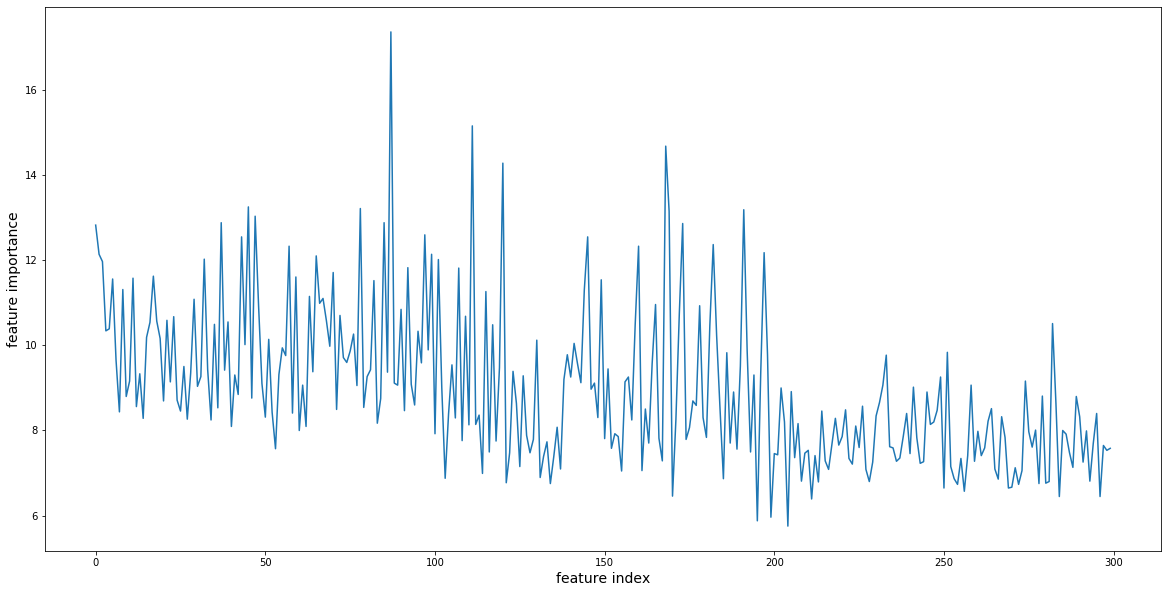

In [378]:
plt.figure(num=None, figsize=(20,10))
plt.plot(average_fis)
plt.xlabel('feature index', fontsize=14)
plt.ylabel('feature importance', fontsize=14)
plt.savefig('negishi_random_smiles_bm_fis.png', dpi=100)

In [379]:
plt.close()

### Randomized Mordred vectors (random Mordred)
A random "barcode" is written for each unique molecule's Mordred vector drawing from a standard normal distribution. Essentially removes any continuity between chemical space, only identifying the unique molecules in a reaction.

In [233]:
X_train_mordred

,rdfred_1_Diameter,rdfred_1_ATSC1m,rdfred_1_piPC3,rdfred_1_n5aHRing,rdfred_1_n4AHRing,rdfred_1_EState_VSA3,rdfred_1_ATS0i,rdfred_1_SaaSe,rdfred_1_CIC3,rdfred_1_ATSC1p,...,product_NsssN,product_VSA_EState8,product_n9FARing,product_GGI6,product_Xch-4d,product_n7AHRing,product_n10ARing,product_PEOE_VSA13,product_n7HRing,product_SMR_VSA9
0,4,-1.901154e+01,3.409496,0,0,0.000000,1679.096540,0.0,-4.440892e-16,-4.247127e-02,...,0,0.829308,0,0.100408,0.0,0,0,0.000000,0,11.387856
1,7,-1.121152e+00,4.226834,0,0,0.000000,3079.061340,0.0,1.000000e+00,-2.023735e-01,...,0,0.800962,0,0.222857,0.0,0,0,0.000000,0,22.775712
2,6,-4.796163e-14,3.669951,0,0,10.586085,2006.630591,0.0,-4.440892e-16,1.304512e-15,...,0,0.000000,0,0.160000,0.0,0,0,0.000000,0,17.196124
3,10,4.178395e+01,3.956040,0,0,11.499024,5049.873711,0.0,1.105312e+00,-1.919692e+00,...,0,0.000000,0,0.503673,0.0,0,0,0.000000,0,11.499024
4,3,3.753147e+02,1.386294,0,0,0.000000,694.916767,0.0,0.000000e+00,-1.360626e+00,...,0,0.000000,0,0.060408,0.0,0,0,0.000000,0,12.343784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6237,11,-4.464207e+01,5.102911,1,0,21.880439,4819.865338,0.0,6.451613e-02,5.450789e-01,...,0,0.000000,0,0.584535,0.0,0,0,5.559267,0,11.387856
6238,8,-4.366625e+00,2.197225,0,0,0.000000,3897.348465,0.0,7.814536e-01,-2.243643e-01,...,0,0.000000,0,0.164082,0.0,0,0,0.000000,0,0.000000
6239,8,-4.366625e+00,2.197225,0,0,0.000000,3897.348465,0.0,7.814536e-01,-2.243643e-01,...,0,0.000000,0,0.164082,0.0,0,0,0.000000,0,0.000000
6240,10,-4.058288e+01,2.890372,0,0,0.000000,5202.853427,0.0,4.846805e-01,1.721917e-01,...,0,0.000000,0,0.204082,0.0,0,0,0.000000,0,0.000000


In [389]:
mordred_max = X_full_mordred.max().max()
mordred_max

122432.04767485715

In [269]:
# Get all unique Mordred vectors from dataset
# Separate molecules
X_full_mordred = pd.DataFrame(
    X_full[X_full.columns[300:]].copy().values, 
    index=X_full.index.values
)
reactant_1_mordred = pd.DataFrame(
    X_full_mordred[X_full_mordred.columns[:668]].copy().values, 
    index=X_full.index.values
)
reactant_2_mordred = pd.DataFrame(
    X_full_mordred[X_full_mordred.columns[668:1336]].copy().values, 
    index=X_full.index.values
)
product_mordred = pd.DataFrame(
    X_full_mordred[X_full_mordred.columns[1336:]].copy().values, 
    index=X_full.index.values
)

# Join tabulated vectors to single lists
for df in [reactant_1_mordred, reactant_2_mordred, product_mordred]:
    df['joined'] = df.values.tolist()
    df['str_joined'] = df['joined'].astype('str')

# Create dataframe with all unique SMILES from the dataset
unique_mordred = pd.concat(
    [reactant_1_mordred, reactant_2_mordred, product_mordred],
    ignore_index=True
)
print(f'Total Mordred vectors: {len(unique_mordred)}')
unique_mordred = unique_mordred.drop_duplicates(subset=['str_joined'])
print(f'Unique Mordred vectors: {len(unique_mordred)}')

# Create random fake vector representations for all unique molecules
unique_mordred['random'] = [
    (np.random.rand(668)*mordred_max).tolist() 
    for _ in range(len(unique_mordred))
]
unique_mordred['str_random'] = unique_mordred['random'].astype('str')
unique_mordred

Total Mordred vectors: 18459
Unique Mordred vectors: 8893


,0,1,2,3,4,5,6,7,8,9,...,662,663,664,665,666,667,joined,str_joined,random,str_random
0,4.0,-1.901154e+01,3.409496,0.0,0.0,0.000000,1679.096540,0.0,-4.440892e-16,-4.247127e-02,...,0.0,0.0,0.0,0.000000,0.0,0.000000,"[4.0, -19.011537090908828, 3.4094961844768505,...","[4.0, -19.011537090908828, 3.4094961844768505,...","[25812.647442681206, 40071.770043054654, 12610...","[25812.647442681206, 40071.770043054654, 12610..."
1,7.0,-1.121152e+00,4.226834,0.0,0.0,0.000000,3079.061340,0.0,1.000000e+00,-2.023735e-01,...,0.0,0.0,0.0,0.000000,0.0,11.387856,"[7.0, -1.121152000000336, 4.226833745268181, 0...","[7.0, -1.121152000000336, 4.226833745268181, 0...","[35821.267841955545, 33431.1196680402, 29072.0...","[35821.267841955545, 33431.1196680402, 29072.0..."
2,6.0,-4.796163e-14,3.669951,0.0,0.0,10.586085,2006.630591,0.0,-4.440892e-16,1.304512e-15,...,0.0,0.0,0.0,0.000000,0.0,6.069221,"[6.0, -4.796163466380676e-14, 3.66995144422841...","[6.0, -4.796163466380676e-14, 3.66995144422841...","[5008.107816518844, 19581.6731385671, 10276.76...","[5008.107816518844, 19581.6731385671, 10276.76..."
3,10.0,4.178395e+01,3.956040,0.0,0.0,11.499024,5049.873711,0.0,1.105312e+00,-1.919692e+00,...,0.0,0.0,0.0,0.000000,0.0,11.499024,"[10.0, 41.78394838709728, 3.9560398908449206, ...","[10.0, 41.78394838709728, 3.9560398908449206, ...","[100656.53455278333, 45665.084285352226, 9051....","[100656.53455278333, 45665.084285352226, 9051...."
4,3.0,3.753147e+02,1.386294,0.0,0.0,0.000000,694.916767,0.0,0.000000e+00,-1.360626e+00,...,0.0,0.0,0.0,0.000000,0.0,10.938124,"[3.0, 375.31466100000017, 1.3862943611198906, ...","[3.0, 375.31466100000017, 1.3862943611198906, ...","[50035.579871210204, 104068.09532328298, 11428...","[50035.579871210204, 104068.09532328298, 11428..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18451,13.0,1.531506e+01,5.011468,1.0,0.0,17.988196,7544.568666,0.0,5.643160e-01,-3.299123e-01,...,0.0,0.0,0.0,0.000000,0.0,16.876415,"[13.0, 15.315062550187328, 5.0114682804001465,...","[13.0, 15.315062550187328, 5.0114682804001465,...","[76739.1847656564, 92366.93272154113, 85374.29...","[76739.1847656564, 92366.93272154113, 85374.29..."
18452,11.0,-2.040456e+01,4.494239,0.0,0.0,27.965112,5013.599879,0.0,3.360902e-01,3.129866e-01,...,0.0,0.0,0.0,0.000000,0.0,11.499024,"[11.0, -20.404561027343853, 4.4942386252808095...","[11.0, -20.404561027343853, 4.4942386252808095...","[65839.72064092434, 22787.979002006166, 98485....","[65839.72064092434, 22787.979002006166, 98485...."
18454,12.0,2.049921e+01,5.120983,1.0,0.0,16.363739,5858.476440,0.0,2.906726e-01,4.714656e-01,...,0.0,0.0,0.0,5.559267,0.0,11.387856,"[12.0, 20.49921275602663, 5.120983351265121, 1...","[12.0, 20.49921275602663, 5.120983351265121, 1...","[81421.11758945283, 71463.3334236212, 56125.03...","[81421.11758945283, 71463.3334236212, 56125.03..."
18457,12.0,-6.175787e+01,3.178054,0.0,0.0,5.917906,6398.595920,0.0,5.708888e-01,-9.350856e-02,...,0.0,0.0,0.0,0.000000,0.0,0.000000,"[12.0, -61.75787482708785, 3.1780538303479458,...","[12.0, -61.75787482708785, 3.1780538303479458,...","[53043.96686619175, 87599.77297832613, 87345.7...","[53043.96686619175, 87599.77297832613, 87345.7..."


In [270]:
# Create mapping from true vectors to random vectors
mordred_random_dict = dict(zip(unique_mordred['str_joined'], unique_mordred['str_random']))
len(mordred_random_dict)

8893

In [271]:
# Apply mapping to all SMILES from the dataset
for df in [reactant_1_mordred, reactant_2_mordred, product_mordred]:
    df['str_random'] = df['str_joined'].map(mordred_random_dict)
    df['random'] = [json.loads(_) for _ in df['str_random']]
reactant_1_mordred

,0,1,2,3,4,5,6,7,8,9,...,662,663,664,665,666,667,joined,str_joined,str_random,random
0,4.0,-1.901154e+01,3.409496,0.0,0.0,0.000000,1679.096540,0.0,-4.440892e-16,-4.247127e-02,...,0.0,0.0,0.0,0.000000,0.0,0.000000,"[4.0, -19.011537090908828, 3.4094961844768505,...","[4.0, -19.011537090908828, 3.4094961844768505,...","[25812.647442681206, 40071.770043054654, 12610...","[25812.647442681206, 40071.770043054654, 12610..."
1,7.0,-1.121152e+00,4.226834,0.0,0.0,0.000000,3079.061340,0.0,1.000000e+00,-2.023735e-01,...,0.0,0.0,0.0,0.000000,0.0,11.387856,"[7.0, -1.121152000000336, 4.226833745268181, 0...","[7.0, -1.121152000000336, 4.226833745268181, 0...","[35821.267841955545, 33431.1196680402, 29072.0...","[35821.267841955545, 33431.1196680402, 29072.0..."
2,6.0,-4.796163e-14,3.669951,0.0,0.0,10.586085,2006.630591,0.0,-4.440892e-16,1.304512e-15,...,0.0,0.0,0.0,0.000000,0.0,6.069221,"[6.0, -4.796163466380676e-14, 3.66995144422841...","[6.0, -4.796163466380676e-14, 3.66995144422841...","[5008.107816518844, 19581.6731385671, 10276.76...","[5008.107816518844, 19581.6731385671, 10276.76..."
3,10.0,4.178395e+01,3.956040,0.0,0.0,11.499024,5049.873711,0.0,1.105312e+00,-1.919692e+00,...,0.0,0.0,0.0,0.000000,0.0,11.499024,"[10.0, 41.78394838709728, 3.9560398908449206, ...","[10.0, 41.78394838709728, 3.9560398908449206, ...","[100656.53455278333, 45665.084285352226, 9051....","[100656.53455278333, 45665.084285352226, 9051...."
4,3.0,3.753147e+02,1.386294,0.0,0.0,0.000000,694.916767,0.0,0.000000e+00,-1.360626e+00,...,0.0,0.0,0.0,0.000000,0.0,10.938124,"[3.0, 375.31466100000017, 1.3862943611198906, ...","[3.0, 375.31466100000017, 1.3862943611198906, ...","[50035.579871210204, 104068.09532328298, 11428...","[50035.579871210204, 104068.09532328298, 11428..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6237,11.0,-4.464207e+01,5.102911,1.0,0.0,21.880439,4819.865338,0.0,6.451613e-02,5.450789e-01,...,0.0,0.0,0.0,5.559267,0.0,11.387856,"[11.0, -44.642068504682605, 5.1029105702054265...","[11.0, -44.642068504682605, 5.1029105702054265...","[71491.00901153339, 11527.172340916428, 10203....","[71491.00901153339, 11527.172340916428, 10203...."
6238,8.0,-4.366625e+00,2.197225,0.0,0.0,0.000000,3897.348465,0.0,7.814536e-01,-2.243643e-01,...,0.0,0.0,0.0,0.000000,0.0,0.000000,"[8.0, -4.366624932883388, 2.19722457733622, 0....","[8.0, -4.366624932883388, 2.19722457733622, 0....","[36370.29618983372, 68074.06911910878, 74228.1...","[36370.29618983372, 68074.06911910878, 74228.1..."
6239,8.0,-4.366625e+00,2.197225,0.0,0.0,0.000000,3897.348465,0.0,7.814536e-01,-2.243643e-01,...,0.0,0.0,0.0,0.000000,0.0,0.000000,"[8.0, -4.366624932883388, 2.19722457733622, 0....","[8.0, -4.366624932883388, 2.19722457733622, 0....","[36370.29618983372, 68074.06911910878, 74228.1...","[36370.29618983372, 68074.06911910878, 74228.1..."
6240,10.0,-4.058288e+01,2.890372,0.0,0.0,0.000000,5202.853427,0.0,4.846805e-01,1.721917e-01,...,0.0,0.0,0.0,0.000000,0.0,0.000000,"[10.0, -40.582879795215796, 2.8903717578961645...","[10.0, -40.582879795215796, 2.8903717578961645...","[39995.93744782583, 71095.2501542809, 19846.75...","[39995.93744782583, 71095.2501542809, 19846.75..."


In [272]:
reactant_2_mordred

,0,1,2,3,4,5,6,7,8,9,...,662,663,664,665,666,667,joined,str_joined,str_random,random
0,5.0,3257.760285,3.358638,0.0,0.0,0.0,1812.699297,0.0,0.000000,5.373827,...,0.0,0.0,0.0,0.0,0.0,0.0,"[5.0, 3257.760284500001, 3.3586377672433594, 0...","[5.0, 3257.760284500001, 3.3586377672433594, 0...","[105098.54788990626, 36942.55532731094, 42451....","[105098.54788990626, 36942.55532731094, 42451...."
1,5.0,3257.760285,3.358638,0.0,0.0,0.0,1812.699297,0.0,0.000000,5.373827,...,0.0,0.0,0.0,0.0,0.0,0.0,"[5.0, 3257.760284500001, 3.3586377672433594, 0...","[5.0, 3257.760284500001, 3.3586377672433594, 0...","[105098.54788990626, 36942.55532731094, 42451....","[105098.54788990626, 36942.55532731094, 42451...."
2,5.0,1161.449020,3.358638,0.0,0.0,0.0,1941.764799,0.0,0.365761,2.214509,...,0.0,0.0,0.0,0.0,0.0,0.0,"[5.0, 1161.449020461539, 3.3586377672433594, 0...","[5.0, 1161.449020461539, 3.3586377672433594, 0...","[32443.8579024728, 9818.570368270804, 17817.88...","[32443.8579024728, 9818.570368270804, 17817.88..."
3,5.0,3622.738280,2.397895,0.0,0.0,0.0,3022.677154,0.0,1.447883,6.827617,...,0.0,0.0,0.0,0.0,0.0,0.0,"[5.0, 3622.738280105263, 2.3978952727983707, 0...","[5.0, 3622.738280105263, 2.3978952727983707, 0...","[41333.057326225906, 24470.855163979853, 92038...","[41333.057326225906, 24470.855163979853, 92038..."
4,9.0,12.458964,2.833213,0.0,0.0,0.0,4395.045392,0.0,0.444444,-0.842545,...,0.0,0.0,0.0,0.0,0.0,0.0,"[9.0, 12.458963973333482, 2.8332133440562166, ...","[9.0, 12.458963973333482, 2.8332133440562166, ...","[19616.592959603426, 58695.419462494145, 81144...","[19616.592959603426, 58695.419462494145, 81144..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6237,4.0,187.327310,1.098612,0.0,0.0,0.0,2444.604919,0.0,1.833985,1.461509,...,0.0,0.0,0.0,0.0,0.0,0.0,"[4.0, 187.3273098400001, 1.0986122886681098, 0...","[4.0, 187.3273098400001, 1.0986122886681098, 0...","[75241.13829615123, 15909.917458852444, 80406....","[75241.13829615123, 15909.917458852444, 80406...."
6238,10.0,1910.211761,3.731699,0.0,0.0,0.0,6475.175303,0.0,1.208509,15.907144,...,0.0,0.0,0.0,0.0,0.0,0.0,"[10.0, 1910.2117606585362, 3.7316994512968646,...","[10.0, 1910.2117606585362, 3.7316994512968646,...","[75131.57551846444, 81616.13045096232, 6582.61...","[75131.57551846444, 81616.13045096232, 6582.61..."
6239,10.0,786.068811,3.946424,0.0,0.0,0.0,8790.649327,0.0,1.978783,11.049058,...,0.0,0.0,0.0,0.0,0.0,0.0,"[10.0, 786.0688110000011, 3.9464244321454784, ...","[10.0, 786.0688110000011, 3.9464244321454784, ...","[68710.8621002445, 44891.74266525858, 41009.61...","[68710.8621002445, 44891.74266525858, 41009.61..."
6240,4.0,3225.941253,1.609438,0.0,0.0,0.0,1532.788174,0.0,0.475489,5.447291,...,0.0,0.0,0.0,0.0,0.0,0.0,"[4.0, 3225.9412526100004, 1.6094379124341005, ...","[4.0, 3225.9412526100004, 1.6094379124341005, ...","[18638.097408259964, 32983.88320237026, 15544....","[18638.097408259964, 32983.88320237026, 15544...."


In [273]:
product_mordred

,0,1,2,3,4,5,6,7,8,9,...,662,663,664,665,666,667,joined,str_joined,str_random,random
0,7.0,1.091092e+00,4.158883,0.0,0.0,0.000000,3124.413121,0.0,0.300000,-2.715956e-01,...,0.0,0.0,0.0,0.000000,0.0,11.387856,"[7.0, 1.0910918399999845, 4.1588830833596715, ...","[7.0, 1.0910918399999845, 4.1588830833596715, ...","[35859.086659429224, 116267.00317759016, 11706...","[35859.086659429224, 116267.00317759016, 11706..."
1,10.0,1.057176e+01,4.627421,0.0,0.0,0.000000,4524.377920,0.0,0.439824,-3.556600e-01,...,0.0,0.0,0.0,0.000000,0.0,22.775712,"[10.0, 10.571755707491256, 4.627420794922911, ...","[10.0, 10.571755707491256, 4.627420794922911, ...","[38950.702172700476, 63639.79860427432, 83345....","[38950.702172700476, 63639.79860427432, 83345...."
2,9.0,1.779776e+01,4.290459,0.0,0.0,5.563451,3523.825560,0.0,0.467604,1.741742e-01,...,0.0,0.0,0.0,0.000000,0.0,17.196124,"[9.0, 17.79775985066125, 4.290459441148391, 0....","[9.0, 17.79775985066125, 4.290459441148391, 0....","[69257.31656952082, 11251.177840518301, 85355....","[69257.31656952082, 11251.177840518301, 85355...."
3,11.0,1.247141e+02,4.193435,0.0,0.0,5.917906,7705.168149,0.0,1.314350,-1.787888e+00,...,0.0,0.0,0.0,0.000000,0.0,11.499024,"[11.0, 124.71408040742467, 4.193435464866331, ...","[11.0, 124.71408040742467, 4.193435464866331, ...","[28994.44574694727, 24189.178721547793, 47627....","[28994.44574694727, 24189.178721547793, 47627...."
4,10.0,4.622560e+01,3.135494,0.0,0.0,6.606882,4724.322921,0.0,0.413793,-1.064785e+00,...,0.0,0.0,0.0,0.000000,0.0,12.343784,"[10.0, 46.22559558620672, 3.1354942159291497, ...","[10.0, 46.22559558620672, 3.1354942159291497, ...","[48576.14933121203, 101690.46353900974, 50000....","[48576.14933121203, 101690.46353900974, 50000...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6237,12.0,2.049921e+01,5.120983,1.0,0.0,16.363739,5858.476440,0.0,0.290673,4.714656e-01,...,0.0,0.0,0.0,5.559267,0.0,11.387856,"[12.0, 20.49921275602663, 5.120983351265121, 1...","[12.0, 20.49921275602663, 5.120983351265121, 1...","[81421.11758945283, 71463.3334236212, 56125.03...","[81421.11758945283, 71463.3334236212, 56125.03..."
6238,14.0,-2.557954e-13,3.865979,0.0,0.0,11.835812,7956.622326,0.0,0.837134,-3.191891e-16,...,0.0,0.0,0.0,0.000000,0.0,0.000000,"[14.0, -2.557953848736361e-13, 3.8659790669267...","[14.0, -2.557953848736361e-13, 3.8659790669267...","[21313.293690643124, 94581.92796597832, 100885...","[21313.293690643124, 94581.92796597832, 100885..."
6239,14.0,-2.557954e-13,3.865979,0.0,0.0,11.835812,7956.622326,0.0,0.837134,-3.191891e-16,...,0.0,0.0,0.0,0.000000,0.0,0.000000,"[14.0, -2.557953848736361e-13, 3.8659790669267...","[14.0, -2.557953848736361e-13, 3.8659790669267...","[21313.293690643124, 94581.92796597832, 100885...","[21313.293690643124, 94581.92796597832, 100885..."
6240,12.0,-6.175787e+01,3.178054,0.0,0.0,5.917906,6398.595920,0.0,0.570889,-9.350856e-02,...,0.0,0.0,0.0,0.000000,0.0,0.000000,"[12.0, -61.75787482708785, 3.1780538303479458,...","[12.0, -61.75787482708785, 3.1780538303479458,...","[53043.96686619175, 87599.77297832613, 87345.7...","[53043.96686619175, 87599.77297832613, 87345.7..."


In [274]:
reactant_1_mordred = pd.DataFrame(
    list(reactant_1_mordred['random'].values), 
    columns=X_full.columns[300:968],
    index=X_full.index.values
)
reactant_2_mordred = pd.DataFrame(
    list(reactant_2_mordred['random'].values), 
    columns=X_full.columns[968:1636],
    index=X_full.index.values
)
product_mordred = pd.DataFrame(
    list(product_mordred['random'].values), 
    columns=X_full.columns[1636:],
    index=X_full.index.values
)
reactant_1_mordred

,rdfred_1_Diameter,rdfred_1_ATSC1m,rdfred_1_piPC3,rdfred_1_n5aHRing,rdfred_1_n4AHRing,rdfred_1_EState_VSA3,rdfred_1_ATS0i,rdfred_1_SaaSe,rdfred_1_CIC3,rdfred_1_ATSC1p,...,rdfred_1_NsssN,rdfred_1_VSA_EState8,rdfred_1_n9FARing,rdfred_1_GGI6,rdfred_1_Xch-4d,rdfred_1_n7AHRing,rdfred_1_n10ARing,rdfred_1_PEOE_VSA13,rdfred_1_n7HRing,rdfred_1_SMR_VSA9
0,25812.647443,40071.770043,12610.085477,47066.586427,119622.320749,85901.531093,18446.119036,79615.895208,57273.634055,33751.392785,...,34802.345590,45565.108536,58.673868,100641.375661,48817.484735,79164.106003,63589.632327,119805.247066,20496.664051,49453.068839
1,35821.267842,33431.119668,29072.061150,10925.503949,83.641934,21222.948488,113405.228271,88242.571897,61244.613347,106699.233555,...,49442.319739,121585.085075,30041.530044,58454.547198,17128.142675,56407.682137,93216.166663,94428.872363,23058.140989,26121.529145
2,5008.107817,19581.673139,10276.760557,68943.373312,32011.618308,11029.059867,32314.092936,105432.501538,51091.787455,100467.583830,...,37471.526023,40531.206113,71622.206666,8199.021009,65220.362912,21839.000536,91230.599092,6872.897652,76498.906792,80307.241339
3,100656.534553,45665.084285,9051.054913,78885.745283,12295.459346,16292.600377,100291.313758,55645.901575,106187.629889,28168.858577,...,59376.389288,68368.480898,76762.587447,25443.359036,121557.785772,101880.152577,28381.157568,105988.935289,120717.831916,6603.226046
4,50035.579871,104068.095323,114287.583683,107438.170520,93905.419881,60247.649146,77948.075154,109679.486322,80322.567765,115932.066268,...,101775.353962,96546.110195,19179.981277,114751.744229,17476.266562,86215.560587,1982.741164,78078.992352,5188.467055,72052.696464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6237,71491.009012,11527.172341,10203.671971,74490.767658,62041.445372,111753.185009,119082.536574,25080.586513,71888.682599,28910.068209,...,120208.447928,59570.432523,62405.560791,105241.270353,115090.407765,76008.632821,36616.942720,980.058607,81569.623451,70655.247151
6238,36370.296190,68074.069119,74228.148847,3547.435381,120117.262707,43299.000022,86082.668595,34199.853020,96813.502208,13390.222554,...,11695.954242,76685.668345,18712.736670,55133.048480,108524.166150,104747.311922,117965.063754,82209.798960,51905.031490,87593.961307
6239,36370.296190,68074.069119,74228.148847,3547.435381,120117.262707,43299.000022,86082.668595,34199.853020,96813.502208,13390.222554,...,11695.954242,76685.668345,18712.736670,55133.048480,108524.166150,104747.311922,117965.063754,82209.798960,51905.031490,87593.961307
6240,39995.937448,71095.250154,19846.758842,50112.927430,23620.934533,20532.625515,14524.253396,72886.545398,55419.480949,6323.227030,...,31468.885438,91620.047679,43739.728030,88873.930240,9275.378661,88509.477443,24751.983815,65610.547041,16509.917314,13335.905074


In [275]:
reactant_2_mordred

,rdfred_2_Diameter,rdfred_2_ATSC1m,rdfred_2_piPC3,rdfred_2_n5aHRing,rdfred_2_n4AHRing,rdfred_2_EState_VSA3,rdfred_2_ATS0i,rdfred_2_SaaSe,rdfred_2_CIC3,rdfred_2_ATSC1p,...,rdfred_2_NsssN,rdfred_2_VSA_EState8,rdfred_2_n9FARing,rdfred_2_GGI6,rdfred_2_Xch-4d,rdfred_2_n7AHRing,rdfred_2_n10ARing,rdfred_2_PEOE_VSA13,rdfred_2_n7HRing,rdfred_2_SMR_VSA9
0,105098.547890,36942.555327,42451.862278,97107.392149,60383.028968,17698.860678,67859.590335,77906.891781,56999.088896,56647.602403,...,52338.801708,108244.057738,80283.872679,101628.734099,80525.285802,69832.540636,74237.501102,91877.670287,96417.309573,96669.454296
1,105098.547890,36942.555327,42451.862278,97107.392149,60383.028968,17698.860678,67859.590335,77906.891781,56999.088896,56647.602403,...,52338.801708,108244.057738,80283.872679,101628.734099,80525.285802,69832.540636,74237.501102,91877.670287,96417.309573,96669.454296
2,32443.857902,9818.570368,17817.884872,76139.766111,74072.986724,38213.903379,69094.526498,4375.649603,83135.927010,30793.990602,...,71035.575243,112818.523371,102542.626967,97738.517833,23749.653861,32340.634304,75543.988186,61921.032385,69945.021327,53664.079297
3,41333.057326,24470.855164,92038.178847,119189.193762,100011.312050,76995.439300,76550.800184,110511.267051,34695.983893,71232.751001,...,40722.660944,52903.119786,95377.120067,43687.494739,91700.516304,112928.148352,83295.513480,120008.147740,35399.883002,96715.748767
4,19616.592960,58695.419462,81144.664872,17326.612623,24218.973244,73518.063081,62041.565965,60565.090722,130.256149,69282.510557,...,13257.714977,49289.602619,11459.652359,41634.419000,60054.979987,42502.959298,509.690832,4621.942786,3757.296104,43885.766155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6237,75241.138296,15909.917459,80406.755925,92167.051723,103718.519333,87159.549880,19292.378018,49547.198783,51850.484702,29648.813975,...,46284.140663,68738.937090,63577.077331,97974.925444,57449.547108,4496.168694,107356.814696,108312.147242,14481.426863,63628.882278
6238,75131.575518,81616.130451,6582.618242,104957.862163,26040.929823,44850.646108,114300.712242,4114.826466,69168.810569,8434.500851,...,56125.672134,49004.126718,30363.592961,19685.041998,56473.159938,11985.046651,114958.374952,22324.544243,57766.520758,35193.180536
6239,68710.862100,44891.742665,41009.612643,33947.429591,59725.858136,59643.042686,108682.268234,73936.080717,108042.192240,98427.215125,...,1939.258739,92013.688604,38374.202669,15937.834078,37201.268183,6295.760449,37721.878002,25004.501605,5549.800474,16705.022544
6240,18638.097408,32983.883202,15544.382224,20698.827778,55187.565300,68725.597770,5405.510545,15154.714631,49399.895287,17901.361768,...,70487.361936,14640.765268,51185.185793,80223.509281,121276.212133,116870.791369,57760.128244,65540.071258,56570.970807,41775.507233


In [276]:
product_mordred

,product_Diameter,product_ATSC1m,product_piPC3,product_n5aHRing,product_n4AHRing,product_EState_VSA3,product_ATS0i,product_SaaSe,product_CIC3,product_ATSC1p,...,product_NsssN,product_VSA_EState8,product_n9FARing,product_GGI6,product_Xch-4d,product_n7AHRing,product_n10ARing,product_PEOE_VSA13,product_n7HRing,product_SMR_VSA9
0,35859.086659,116267.003178,117069.027228,93001.326477,55429.993755,119233.975054,19965.703550,4656.790278,47635.544596,10961.416680,...,22166.213988,35902.867390,91283.113114,102544.953129,50503.769160,54885.434500,56933.356565,102096.815513,10285.718166,105620.653800
1,38950.702173,63639.798604,83345.288915,79588.735446,8573.641140,113821.680114,67896.001366,61419.452105,14297.319779,45235.612624,...,10649.846099,102618.797261,57617.058436,117276.432948,38608.483876,77625.046134,96214.649936,78676.745547,93066.647856,11851.108170
2,69257.316570,11251.177841,85355.439417,94517.781958,15214.913602,40299.005423,42732.578459,5529.547447,48934.658225,55586.070948,...,81891.685112,37050.341321,75300.342264,104951.075332,48276.471912,32917.539521,96990.682453,16273.678906,393.662087,3377.788549
3,28994.445747,24189.178722,47627.158666,101147.304634,25267.852607,89832.523803,52425.071433,86703.036877,218.423012,75873.984501,...,44440.428084,16681.730903,99198.933260,66031.755627,75583.755710,95705.044363,52280.658041,4811.162648,104513.487784,61446.154992
4,48576.149331,101690.463539,50000.134784,82737.387013,63773.128301,25754.650025,8207.120332,116015.771958,28924.507705,11053.742120,...,87435.862718,52586.076715,36588.511128,87141.446195,115649.324159,91925.961848,21674.413579,116487.424378,74875.395968,29668.299715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6237,81421.117589,71463.333424,56125.031213,40300.305100,38050.078191,61423.425454,69226.431308,77409.503167,77433.684011,111924.041032,...,16710.228248,7747.235844,19068.668738,86525.817168,116135.115953,88939.886475,33031.147624,50037.608999,78681.032826,63961.574332
6238,21313.293691,94581.927966,100885.894723,30423.712720,50816.039469,76812.662480,7305.755286,95261.554341,51294.447533,97171.750720,...,30451.902977,101615.396806,109831.563445,51796.072867,57530.636815,70341.884700,32907.022285,116987.129123,76084.129711,8093.761464
6239,21313.293691,94581.927966,100885.894723,30423.712720,50816.039469,76812.662480,7305.755286,95261.554341,51294.447533,97171.750720,...,30451.902977,101615.396806,109831.563445,51796.072867,57530.636815,70341.884700,32907.022285,116987.129123,76084.129711,8093.761464
6240,53043.966866,87599.772978,87345.757712,63329.247560,67893.099447,67931.877279,48033.850213,28490.351542,63131.774432,74661.078846,...,91142.830702,86635.333510,112360.506480,62588.565067,72030.612782,25715.762964,84424.233452,109394.103464,26721.540230,78390.796309


In [277]:
# Re-combine component molecules into full dataframe
X_full_random_mordred = pd.concat(
    [reactant_1_mordred, reactant_2_mordred, product_mordred], axis=1
)

# View new dataframe
X_full_random_mordred

,rdfred_1_Diameter,rdfred_1_ATSC1m,rdfred_1_piPC3,rdfred_1_n5aHRing,rdfred_1_n4AHRing,rdfred_1_EState_VSA3,rdfred_1_ATS0i,rdfred_1_SaaSe,rdfred_1_CIC3,rdfred_1_ATSC1p,...,product_NsssN,product_VSA_EState8,product_n9FARing,product_GGI6,product_Xch-4d,product_n7AHRing,product_n10ARing,product_PEOE_VSA13,product_n7HRing,product_SMR_VSA9
0,25812.647443,40071.770043,12610.085477,47066.586427,119622.320749,85901.531093,18446.119036,79615.895208,57273.634055,33751.392785,...,22166.213988,35902.867390,91283.113114,102544.953129,50503.769160,54885.434500,56933.356565,102096.815513,10285.718166,105620.653800
1,35821.267842,33431.119668,29072.061150,10925.503949,83.641934,21222.948488,113405.228271,88242.571897,61244.613347,106699.233555,...,10649.846099,102618.797261,57617.058436,117276.432948,38608.483876,77625.046134,96214.649936,78676.745547,93066.647856,11851.108170
2,5008.107817,19581.673139,10276.760557,68943.373312,32011.618308,11029.059867,32314.092936,105432.501538,51091.787455,100467.583830,...,81891.685112,37050.341321,75300.342264,104951.075332,48276.471912,32917.539521,96990.682453,16273.678906,393.662087,3377.788549
3,100656.534553,45665.084285,9051.054913,78885.745283,12295.459346,16292.600377,100291.313758,55645.901575,106187.629889,28168.858577,...,44440.428084,16681.730903,99198.933260,66031.755627,75583.755710,95705.044363,52280.658041,4811.162648,104513.487784,61446.154992
4,50035.579871,104068.095323,114287.583683,107438.170520,93905.419881,60247.649146,77948.075154,109679.486322,80322.567765,115932.066268,...,87435.862718,52586.076715,36588.511128,87141.446195,115649.324159,91925.961848,21674.413579,116487.424378,74875.395968,29668.299715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6237,71491.009012,11527.172341,10203.671971,74490.767658,62041.445372,111753.185009,119082.536574,25080.586513,71888.682599,28910.068209,...,16710.228248,7747.235844,19068.668738,86525.817168,116135.115953,88939.886475,33031.147624,50037.608999,78681.032826,63961.574332
6238,36370.296190,68074.069119,74228.148847,3547.435381,120117.262707,43299.000022,86082.668595,34199.853020,96813.502208,13390.222554,...,30451.902977,101615.396806,109831.563445,51796.072867,57530.636815,70341.884700,32907.022285,116987.129123,76084.129711,8093.761464
6239,36370.296190,68074.069119,74228.148847,3547.435381,120117.262707,43299.000022,86082.668595,34199.853020,96813.502208,13390.222554,...,30451.902977,101615.396806,109831.563445,51796.072867,57530.636815,70341.884700,32907.022285,116987.129123,76084.129711,8093.761464
6240,39995.937448,71095.250154,19846.758842,50112.927430,23620.934533,20532.625515,14524.253396,72886.545398,55419.480949,6323.227030,...,91142.830702,86635.333510,112360.506480,62588.565067,72030.612782,25715.762964,84424.233452,109394.103464,26721.540230,78390.796309


In [278]:
# Re-split full dataset based on test indices
X_train_random_mordred = X_full_random_mordred[
    ~X_full_random_mordred.index.isin(test_inds)
]
X_test_random_mordred = X_full_random_mordred[
    X_full_random_mordred.index.isin(test_inds)
]

# Check sets
print(X_train_random_mordred.shape, y_train.shape, 
      X_test_random_mordred.shape, y_test.shape)

(5534, 2004) (5534, 107) (619, 2004) (619, 107)


In [279]:
# Re-train and test model
start_time = time.time()
random_mordred_file = 'random_mordred_bm_gbm.model.joblib'
random_mordred_bm_gbm = train_lgbm_classifier(
    X_train_random_mordred, y_train, random_mordred_file
)
print(f'Training complete. Training time: {time.time()-start_time} s')

# Make predictions with trained model
random_mordred_preds = random_mordred_bm_gbm.predict_proba(
    X_test_random_mordred
)

# Get top-k predicted rankings from prediction set
random_mordred_preds_labeled = get_top_k_preds(
    random_mordred_preds, cutoffs, category_initials, k=3, include_nulls=True
)

# Get labels from ground truth
y_test_labeled = label_ground_truth(y_test, cutoffs, category_initials,
                                    include_nulls=True)

# Format results for performance metric calculations
type_count = get_type_count(cutoffs, category_initials)
random_mordred_formatted_results = format_results_for_metrics(
    random_mordred_preds_labeled, y_test_labeled, type_count, category_initials
)

# Calculate metrics and save results file
random_mordred_metrics = get_metrics_dict(
    random_mordred_formatted_results, type_count, 'random_mordred_metrics.json'
)

# View top-1 and top-3 accuracy metrics
random_mordred_top_1_acc = random_mordred_metrics['top_1_acc']
random_mordred_top_3_acc = random_mordred_metrics['top_k_acc']

/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 88 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 105 is present in all training examples.
  str(classes[c]))


Training complete. Training time: 1260.665843963623 s
Top 1 accuracy for type  M  : 0.33279483037156704
Top 3 accuracy for type  M  : 0.6122778675282714
Top 1 accuracy for type  L  : 0.7722132471728594
Top 3 accuracy for type  L  : 0.8739903069466882
Top 1 accuracy for type  S  : 0.7075928917609047
Top 3 accuracy for type  S  : 0.8852988691437803
Top 1 accuracy for type  A  : 0.8303715670436187
Top 3 accuracy for type  A  : 0.9159935379644588
Top 1 accuracy for type  T  : 0.5331179321486268
Top 3 accuracy for type  T  : 0.8077544426494345
Top 1 accuracy for type  O  : 0.8061389337641357
Top 3 accuracy for type  O  : 1.0


### Feature importances

In [380]:
num_estimators = len(random_mordred_bm_gbm.estimators_)
all_fis = []

for i in range(num_estimators):
    try:
        all_fis.append(random_mordred_bm_gbm.estimators_[i].feature_importances_) 
    except:
        continue
             
average_fis = np.average(np.array(all_fis), axis=0)
sorted_fis = np.argsort(-average_fis)
mordred_fi_names = X_train_random_mordred.columns[sorted_fis]

mordred_fi_df = pd.DataFrame(
    list(zip(mordred_fi_names, average_fis[sorted_fis])), 
    columns=['mordred_descriptor', 'fi_score']
)
mordred_fi_df.to_csv('negishi_random_mordred_fis.csv')

top_fis = sorted_fis[:20]

top_fi_names = X_train_random_mordred.columns[top_fis]

print(top_fi_names)

Index(['rdfred_2_GGI3', 'rdfred_1_NsssCH', 'rdfred_1_Xch-3d',
       'rdfred_1_EState_VSA1', 'rdfred_2_ATSC3m', 'rdfred_1_ZMIC3',
       'product_n8HRing', 'rdfred_2_SsNH2', 'rdfred_1_Diameter',
       'product_ATSC3i', 'rdfred_1_ATSC2m', 'product_SlogP_VSA8',
       'rdfred_2_EState_VSA10', 'rdfred_1_ATS6i', 'rdfred_1_Xc-4dv',
       'product_NdssS', 'rdfred_1_ATSC5Z', 'product_SssssB', 'rdfred_2_Sare',
       'rdfred_1_NssSiH2'],
      dtype='object')


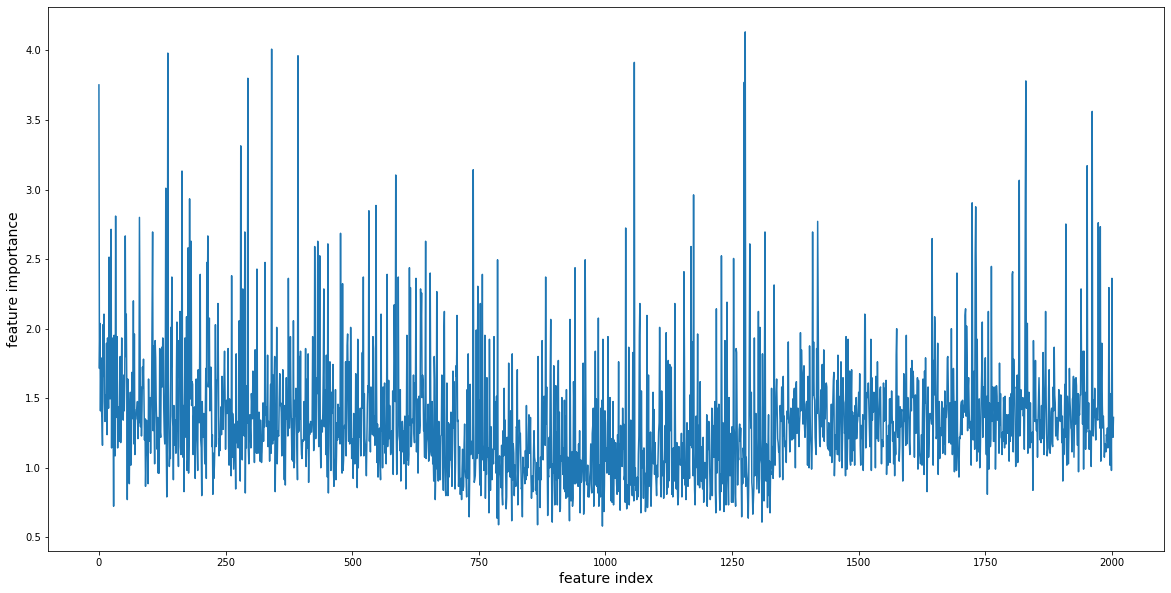

In [382]:
plt.figure(num=None, figsize=(20,10))
plt.plot(average_fis)
plt.xlabel('feature index', fontsize=14)
plt.ylabel('feature importance', fontsize=14)
plt.savefig('negishi_random_mordred_bm_fis.png', dpi=100)

In [326]:
plt.close()

### Shuffle Mordred vectors, leaving outputs the same (shuffle Mordred)
Trains model on fake reactions, testing on same test set of real ones

In [283]:
# Show Mordred dataset for comparison
X_train_mordred

,rdfred_1_Diameter,rdfred_1_ATSC1m,rdfred_1_piPC3,rdfred_1_n5aHRing,rdfred_1_n4AHRing,rdfred_1_EState_VSA3,rdfred_1_ATS0i,rdfred_1_SaaSe,rdfred_1_CIC3,rdfred_1_ATSC1p,...,product_NsssN,product_VSA_EState8,product_n9FARing,product_GGI6,product_Xch-4d,product_n7AHRing,product_n10ARing,product_PEOE_VSA13,product_n7HRing,product_SMR_VSA9
0,4,-1.901154e+01,3.409496,0,0,0.000000,1679.096540,0.0,-4.440892e-16,-4.247127e-02,...,0,0.829308,0,0.100408,0.0,0,0,0.000000,0,11.387856
1,7,-1.121152e+00,4.226834,0,0,0.000000,3079.061340,0.0,1.000000e+00,-2.023735e-01,...,0,0.800962,0,0.222857,0.0,0,0,0.000000,0,22.775712
2,6,-4.796163e-14,3.669951,0,0,10.586085,2006.630591,0.0,-4.440892e-16,1.304512e-15,...,0,0.000000,0,0.160000,0.0,0,0,0.000000,0,17.196124
3,10,4.178395e+01,3.956040,0,0,11.499024,5049.873711,0.0,1.105312e+00,-1.919692e+00,...,0,0.000000,0,0.503673,0.0,0,0,0.000000,0,11.499024
4,3,3.753147e+02,1.386294,0,0,0.000000,694.916767,0.0,0.000000e+00,-1.360626e+00,...,0,0.000000,0,0.060408,0.0,0,0,0.000000,0,12.343784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6237,11,-4.464207e+01,5.102911,1,0,21.880439,4819.865338,0.0,6.451613e-02,5.450789e-01,...,0,0.000000,0,0.584535,0.0,0,0,5.559267,0,11.387856
6238,8,-4.366625e+00,2.197225,0,0,0.000000,3897.348465,0.0,7.814536e-01,-2.243643e-01,...,0,0.000000,0,0.164082,0.0,0,0,0.000000,0,0.000000
6239,8,-4.366625e+00,2.197225,0,0,0.000000,3897.348465,0.0,7.814536e-01,-2.243643e-01,...,0,0.000000,0,0.164082,0.0,0,0,0.000000,0,0.000000
6240,10,-4.058288e+01,2.890372,0,0,0.000000,5202.853427,0.0,4.846805e-01,1.721917e-01,...,0,0.000000,0,0.204082,0.0,0,0,0.000000,0,0.000000


In [285]:
# Shuffle row ordering removing index
X_train_mordred_shuffle = np.random.permutation(X_train_mordred.copy().values)

# Create new dataframe with the shuffled rows, retaining original indices
X_train_mordred_shuffle_inputs = pd.DataFrame(
    X_train_mordred_shuffle, index=X_train_mordred.index, 
    columns=X_train_mordred.columns
)

# View new dataframe (can see inputs have changed)
X_train_mordred_shuffle_inputs

,rdfred_1_Diameter,rdfred_1_ATSC1m,rdfred_1_piPC3,rdfred_1_n5aHRing,rdfred_1_n4AHRing,rdfred_1_EState_VSA3,rdfred_1_ATS0i,rdfred_1_SaaSe,rdfred_1_CIC3,rdfred_1_ATSC1p,...,product_NsssN,product_VSA_EState8,product_n9FARing,product_GGI6,product_Xch-4d,product_n7AHRing,product_n10ARing,product_PEOE_VSA13,product_n7HRing,product_SMR_VSA9
0,12.0,10.233023,4.620059,0.0,0.0,11.436898,5551.039027,0.0,0.285714,-0.363743,...,0.0,0.000000,1.0,0.479229,0.288675,0.0,0.0,0.000000,0.0,17.248535
1,14.0,542.329895,4.524502,0.0,0.0,18.405095,9003.604593,0.0,1.132813,-2.036861,...,1.0,0.000000,0.0,0.575646,0.000000,0.0,0.0,0.000000,0.0,6.069221
2,13.0,5.667826,4.933574,1.0,0.0,39.652142,6391.678601,0.0,0.432432,-0.329062,...,0.0,50.572789,0.0,0.930794,0.000000,0.0,0.0,0.000000,0.0,40.083004
3,15.0,717.312980,4.617593,0.0,0.0,13.213764,14249.087799,0.0,2.461449,2.705811,...,0.0,26.462655,0.0,1.633605,0.000000,0.0,0.0,0.000000,0.0,11.257379
4,5.0,0.257162,4.226834,0.0,0.0,0.000000,2701.932996,0.0,0.486383,0.098263,...,0.0,0.000000,0.0,0.120816,0.000000,0.0,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6237,7.0,52.866766,3.974998,0.0,0.0,11.436898,3011.556003,0.0,0.210526,-1.561709,...,0.0,22.703589,0.0,0.392744,0.288675,0.0,0.0,10.023291,0.0,5.749512
6238,6.0,1346.942798,2.397895,0.0,0.0,5.015161,3422.173283,0.0,1.680201,3.180370,...,0.0,14.579455,0.0,1.179592,0.000000,0.0,0.0,5.907180,0.0,11.499024
6239,9.0,429.401918,3.526361,0.0,0.0,6.420822,5119.424225,0.0,1.043609,-1.850031,...,0.0,0.000000,0.0,0.142041,0.000000,0.0,0.0,0.000000,0.0,0.000000
6240,9.0,-8.594772,4.290459,0.0,0.0,5.879988,3831.277196,0.0,0.190196,-0.264228,...,0.0,0.858538,0.0,0.302857,0.000000,0.0,0.0,0.000000,0.0,11.629500


In [286]:
# But indices have stayed the same
X_train_mordred_shuffle_inputs.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,   10,
            ...
            6232, 6233, 6234, 6235, 6236, 6237, 6238, 6239, 6240, 6241],
           dtype='int64', length=5534)

In [287]:
X_train_mordred.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,   10,
            ...
            6232, 6233, 6234, 6235, 6236, 6237, 6238, 6239, 6240, 6241],
           dtype='int64', length=5534)

In [288]:
# Check test set
X_test_mordred

,rdfred_1_Diameter,rdfred_1_ATSC1m,rdfred_1_piPC3,rdfred_1_n5aHRing,rdfred_1_n4AHRing,rdfred_1_EState_VSA3,rdfred_1_ATS0i,rdfred_1_SaaSe,rdfred_1_CIC3,rdfred_1_ATSC1p,...,product_NsssN,product_VSA_EState8,product_n9FARing,product_GGI6,product_Xch-4d,product_n7AHRing,product_n10ARing,product_PEOE_VSA13,product_n7HRing,product_SMR_VSA9
9,7,24.237428,3.993603,0,0,0.000000,4208.663890,0.0,1.280162,0.421077,...,0,0.000000,0,0.244898,0.0,0,0,5.687386,0,6.069221
21,15,20.730381,5.005623,0,0,43.987703,9576.721130,0.0,0.839149,-0.125260,...,2,0.000000,0,0.990204,0.0,0,0,5.907180,0,23.206589
25,7,-37.780068,4.226834,0,0,0.000000,3510.808298,0.0,0.206734,0.686486,...,0,0.000000,0,0.122449,0.0,0,0,0.000000,0,22.945636
27,7,-37.780068,4.226834,0,0,0.000000,3510.808298,0.0,0.206734,0.686486,...,0,0.000000,0,0.122449,0.0,0,0,0.000000,0,22.945636
32,6,-0.645920,3.907010,0,0,0.000000,2730.610243,0.0,0.279699,-0.533078,...,0,0.000000,0,0.080816,0.0,0,0,0.000000,0,6.069221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6213,4,782.156745,3.233764,1,0,0.000000,1425.670590,0.0,0.000000,0.588489,...,0,6.631640,0,0.645578,0.0,0,0,0.000000,0,16.190111
6224,6,-10.433722,3.504055,0,0,0.000000,2476.664178,0.0,0.297180,-0.228417,...,0,5.777326,0,0.187710,0.0,0,0,0.000000,0,28.527386
6226,8,302.478427,4.516339,0,0,10.772448,4263.507025,0.0,0.620391,-1.657869,...,0,5.952742,0,0.272744,0.0,0,0,0.000000,0,22.777874
6228,5,4.426926,4.226834,0,0,0.000000,2671.595961,0.0,0.750543,0.034481,...,0,5.851075,0,0.248299,0.0,0,0,0.000000,0,11.454175


In [289]:
# Re-train and test model
start_time = time.time()
shuffle_mordred_file = 'shuffle_mordred_bm_gbm.model.joblib'
shuffle_mordred_bm_gbm = train_lgbm_classifier(
    X_train_mordred_shuffle_inputs, y_train, shuffle_mordred_file
)
print(f'Training complete. Training time: {time.time()-start_time} s')

# Make predictions with trained model
shuffle_mordred_bm_preds = shuffle_mordred_bm_gbm.predict_proba(X_test_mordred)

# Get top-k predicted rankings from prediction set
shuffle_mordred_bm_preds_labeled = get_top_k_preds(
    shuffle_mordred_bm_preds, cutoffs, category_initials, k=3, 
    include_nulls=True
)

# Get labels from ground truth
y_test_labeled = label_ground_truth(
    y_test, cutoffs, category_initials, include_nulls=True
)

# Format results for performance metric calculations
type_count = get_type_count(cutoffs, category_initials)
shuffle_mordred_bm_formatted_results = format_results_for_metrics(
    shuffle_mordred_bm_preds_labeled, y_test_labeled, type_count, 
    category_initials
)

# Calculate metrics and save results file
shuffle_mordred_bm_metrics = get_metrics_dict(
    shuffle_mordred_bm_formatted_results, type_count, 
    'shuffle_mordred_bm_metrics.json'
)

# View top-1 and top-3 accuracy metrics
shuffle_mordred_top_1_acc = shuffle_mordred_bm_metrics['top_1_acc']
shuffle_mordred_top_3_acc = shuffle_mordred_bm_metrics['top_k_acc']

/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 88 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 105 is present in all training examples.
  str(classes[c]))


Training complete. Training time: 747.3745820522308 s
Top 1 accuracy for type  M  : 0.23424878836833601
Top 3 accuracy for type  M  : 0.4555735056542811
Top 1 accuracy for type  L  : 0.752827140549273
Top 3 accuracy for type  L  : 0.8352180936995154
Top 1 accuracy for type  S  : 0.6736672051696284
Top 3 accuracy for type  S  : 0.8626817447495961
Top 1 accuracy for type  A  : 0.8061389337641357
Top 3 accuracy for type  A  : 0.8982229402261712
Top 1 accuracy for type  T  : 0.26978998384491115
Top 3 accuracy for type  T  : 0.5282714054927302
Top 1 accuracy for type  O  : 0.8255250403877221
Top 3 accuracy for type  O  : 1.0


### Feature importances

In [383]:
num_estimators = len(shuffle_mordred_bm_gbm.estimators_)
all_fis = []

for i in range(num_estimators):
    try:
        all_fis.append(
            shuffle_mordred_bm_gbm.estimators_[i].feature_importances_
        ) 
    except:
        continue
             
average_fis = np.average(np.array(all_fis), axis=0)

top_fis = np.argsort(-average_fis)[:20]

top_fi_names = X_train_mordred_shuffle_inputs.columns[top_fis]

print(top_fi_names)

Index(['product_JGI4', 'product_JGI6', 'product_JGI5', 'product_ATSC7i',
       'product_JGI7', 'product_ATSC8i', 'product_JGI9', 'product_JGI3',
       'product_ATSC6i', 'product_ATSC5i', 'product_ATSC2i', 'product_JGI2',
       'product_ATSC6dv', 'product_ATSC2d', 'product_JGI8', 'product_ATSC8d',
       'product_EState_VSA6', 'product_ATSC8se', 'product_ATSC8dv',
       'product_ATSC7p'],
      dtype='object')


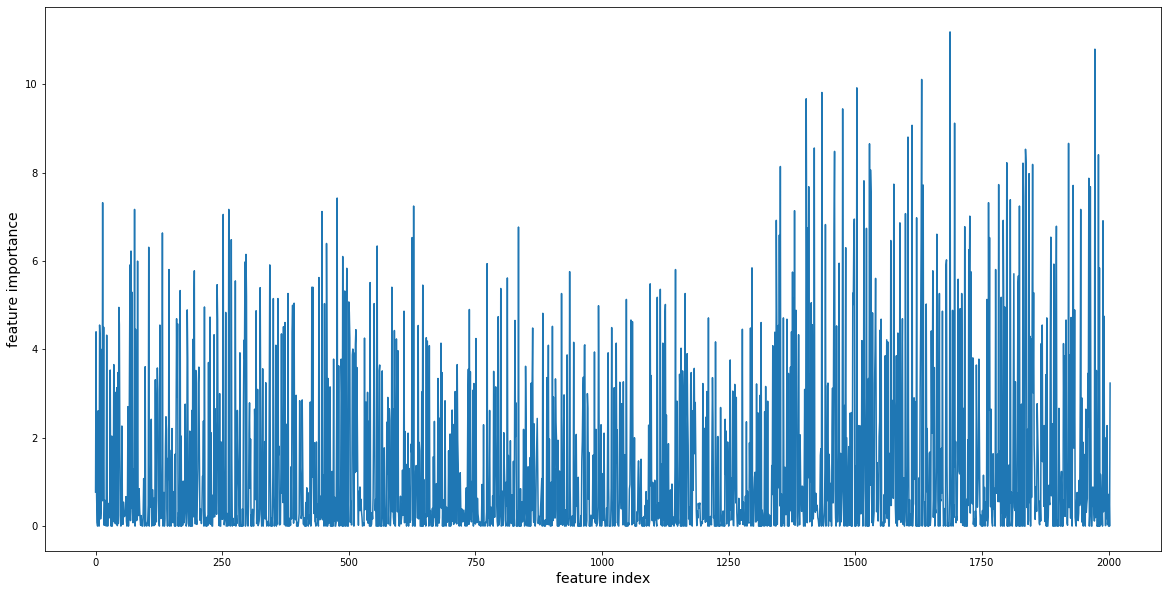

In [384]:
plt.figure(num=None, figsize=(20,10))
plt.plot(average_fis)
plt.xlabel('feature index', fontsize=14)
plt.ylabel('feature importance', fontsize=14)
plt.savefig('negishi_shuffle_mordred_bm_fis.png', dpi=100)

In [385]:
plt.close()

## Fully random inputs (random inputs)
Combine random SMILES and random Mordred inputs

In [338]:
# Re-combine random SMILES and random Mordred dataframes
X_train_random_inputs = pd.concat(
    [X_train_random_smiles, X_train_random_mordred], axis=1
)
X_test_random_inputs = pd.concat(
    [X_test_random_smiles, X_test_random_mordred], axis=1
)

# View new dataframe
X_train_random_inputs

,0,1,2,3,4,5,6,7,8,9,...,product_NsssN,product_VSA_EState8,product_n9FARing,product_GGI6,product_Xch-4d,product_n7AHRing,product_n10ARing,product_PEOE_VSA13,product_n7HRing,product_SMR_VSA9
0,68,100,35,66,83,8,92,71,1,27,...,22166.213988,35902.867390,91283.113114,102544.953129,50503.769160,54885.434500,56933.356565,102096.815513,10285.718166,105620.653800
1,89,100,71,105,18,31,41,1,67,27,...,10649.846099,102618.797261,57617.058436,117276.432948,38608.483876,77625.046134,96214.649936,78676.745547,93066.647856,11851.108170
2,42,99,5,31,14,104,52,7,60,56,...,81891.685112,37050.341321,75300.342264,104951.075332,48276.471912,32917.539521,96990.682453,16273.678906,393.662087,3377.788549
3,26,36,76,59,53,67,55,28,55,19,...,44440.428084,16681.730903,99198.933260,66031.755627,75583.755710,95705.044363,52280.658041,4811.162648,104513.487784,61446.154992
4,79,92,71,15,23,21,4,58,113,39,...,87435.862718,52586.076715,36588.511128,87141.446195,115649.324159,91925.961848,21674.413579,116487.424378,74875.395968,29668.299715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6237,4,47,13,65,108,83,24,26,17,21,...,16710.228248,7747.235844,19068.668738,86525.817168,116135.115953,88939.886475,33031.147624,50037.608999,78681.032826,63961.574332
6238,65,0,45,73,73,89,90,102,47,52,...,30451.902977,101615.396806,109831.563445,51796.072867,57530.636815,70341.884700,32907.022285,116987.129123,76084.129711,8093.761464
6239,19,50,75,67,19,89,29,95,64,46,...,30451.902977,101615.396806,109831.563445,51796.072867,57530.636815,70341.884700,32907.022285,116987.129123,76084.129711,8093.761464
6240,48,53,94,100,45,30,62,107,19,83,...,91142.830702,86635.333510,112360.506480,62588.565067,72030.612782,25715.762964,84424.233452,109394.103464,26721.540230,78390.796309


In [339]:
# Compare to original dataset
X_train

,0,1,2,3,4,5,6,7,8,9,...,product_NsssN,product_VSA_EState8,product_n9FARing,product_GGI6,product_Xch-4d,product_n7AHRing,product_n10ARing,product_PEOE_VSA13,product_n7HRing,product_SMR_VSA9
0,66.0,114.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,67.0,...,0,0.829308,0,0.100408,0.0,0,0,0.000000,0,11.387856
1,66.0,114.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,67.0,...,0,0.800962,0,0.222857,0.0,0,0,0.000000,0,22.775712
2,67.0,108.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,40.0,...,0,0.000000,0,0.160000,0.0,0,0,0.000000,0,17.196124
3,67.0,79.0,67.0,79.0,67.0,49.0,61.0,67.0,67.0,40.0,...,0,0.000000,0,0.503673,0.0,0,0,0.000000,0,11.499024
4,67.0,108.0,91.0,90.0,110.0,93.0,67.0,35.0,67.0,0.0,...,0,0.000000,0,0.060408,0.0,0,0,0.000000,0,12.343784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6237,70.0,83.0,40.0,61.0,79.0,41.0,40.0,61.0,79.0,41.0,...,0,0.000000,0,0.584535,0.0,0,0,5.559267,0,11.387856
6238,70.0,83.0,40.0,61.0,79.0,41.0,40.0,61.0,79.0,41.0,...,0,0.000000,0,0.164082,0.0,0,0,0.000000,0,0.000000
6239,67.0,67.0,67.0,67.0,67.0,92.0,67.0,40.0,67.0,41.0,...,0,0.000000,0,0.164082,0.0,0,0,0.000000,0,0.000000
6240,67.0,79.0,67.0,79.0,67.0,49.0,61.0,67.0,40.0,67.0,...,0,0.000000,0,0.204082,0.0,0,0,0.000000,0,0.000000


In [340]:
X_test_random_inputs

,0,1,2,3,4,5,6,7,8,9,...,product_NsssN,product_VSA_EState8,product_n9FARing,product_GGI6,product_Xch-4d,product_n7AHRing,product_n10ARing,product_PEOE_VSA13,product_n7HRing,product_SMR_VSA9
9,33,63,92,0,78,73,76,38,3,98,...,117248.035971,105954.864313,89327.121785,4534.439579,80997.482213,44557.247056,37412.411221,93058.640085,81271.575527,119024.039849
21,27,73,44,54,12,29,60,92,102,7,...,115964.393694,23646.747705,13261.573406,119649.639313,43874.300324,19312.462594,83667.416190,99942.430394,69640.572970,112854.452891
25,110,74,81,8,25,30,23,17,11,104,...,51918.201919,102580.006331,63583.070033,118321.228950,84695.086987,79659.622725,52854.200756,116113.335512,69212.608244,12590.894619
27,110,74,81,8,25,30,23,17,11,104,...,51918.201919,102580.006331,63583.070033,118321.228950,84695.086987,79659.622725,52854.200756,116113.335512,69212.608244,12590.894619
32,35,6,1,17,113,73,70,102,0,28,...,72464.002006,92284.825510,108578.069041,31140.393662,119629.679226,73129.295074,63717.452780,59298.126663,83650.581368,79194.181795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6213,34,52,80,97,42,82,44,13,59,76,...,5822.779295,26375.724659,43121.226788,69154.676666,63187.748570,77079.066431,2902.657100,47694.396340,111233.100716,104077.596502
6224,100,86,110,30,84,23,84,104,94,2,...,64948.824591,35412.992017,38992.383614,71908.161467,78191.680045,82324.349736,20899.797349,113505.025130,56439.363976,70446.576345
6226,100,45,75,5,80,49,49,71,3,12,...,109106.595818,47677.658975,91306.429935,9929.381340,87274.132074,117716.668532,116629.694183,27243.992114,79905.901456,101723.550209
6228,67,39,90,84,45,59,12,90,98,88,...,64933.385019,74894.908833,66021.422476,82941.329634,12440.823005,71871.225089,61717.530429,14932.256300,21589.835585,105399.754262


In [341]:
X_test

,0,1,2,3,4,5,6,7,8,9,...,product_NsssN,product_VSA_EState8,product_n9FARing,product_GGI6,product_Xch-4d,product_n7AHRing,product_n10ARing,product_PEOE_VSA13,product_n7HRing,product_SMR_VSA9
9,67.0,67.0,40.0,67.0,41.0,40.0,67.0,41.0,67.0,49.0,...,0,0.000000,0,0.244898,0.0,0,0,5.687386,0,6.069221
21,67.0,67.0,40.0,67.0,41.0,67.0,91.0,67.0,64.0,64.0,...,2,0.000000,0,0.990204,0.0,0,0,5.907180,0,23.206589
25,79.0,67.0,49.0,61.0,67.0,67.0,40.0,66.0,114.0,41.0,...,0,0.000000,0,0.122449,0.0,0,0,0.000000,0,22.945636
27,79.0,67.0,49.0,61.0,67.0,67.0,40.0,66.0,114.0,41.0,...,0,0.000000,0,0.122449,0.0,0,0,0.000000,0,22.945636
32,67.0,79.0,67.0,40.0,61.0,79.0,41.0,67.0,49.0,61.0,...,0,0.000000,0,0.080816,0.0,0,0,0.000000,0,6.069221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6213,67.0,108.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,67.0,...,0,6.631640,0,0.645578,0.0,0,0,0.000000,0,16.190111
6224,79.0,67.0,40.0,61.0,79.0,41.0,92.0,67.0,61.0,67.0,...,0,5.777326,0,0.187710,0.0,0,0,0.000000,0,28.527386
6226,79.0,67.0,40.0,61.0,79.0,41.0,92.0,67.0,61.0,67.0,...,0,5.952742,0,0.272744,0.0,0,0,0.000000,0,22.777874
6228,79.0,67.0,92.0,67.0,61.0,67.0,40.0,47.0,73.0,41.0,...,0,5.851075,0,0.248299,0.0,0,0,0.000000,0,11.454175


In [342]:
# Re-train and test model
start_time = time.time()
random_inputs_file = 'random_inputs_bm_gbm.model.joblib'
random_inputs_bm_gbm = train_lgbm_classifier(
    X_train_random_inputs, y_train, random_inputs_file
)
print(f'Training complete. Training time: {time.time()-start_time} s')

# Make predictions with trained model
random_inputs_preds = random_inputs_bm_gbm.predict_proba(
    X_test_random_inputs
)

# Get top-k predicted rankings from prediction set
random_inputs_preds_labeled = get_top_k_preds(
    random_inputs_preds, cutoffs, category_initials, k=3, include_nulls=True
)

# Get labels from ground truth
y_test_labeled = label_ground_truth(
    y_test, cutoffs, category_initials, include_nulls=True
)

# Format results for performance metric calculations
type_count = get_type_count(cutoffs, category_initials)
random_inputs_formatted_results = format_results_for_metrics(
    random_inputs_preds_labeled, y_test_labeled, type_count, category_initials
)

# Calculate metrics and save results file
random_inputs_metrics = get_metrics_dict(
    random_inputs_formatted_results, type_count, 'random_inputs_metrics.json'
)

# View top-1 and top-3 accuracy metrics
random_inputs_top_1_acc = random_inputs_metrics['top_1_acc']
random_inputs_top_3_acc = random_inputs_metrics['top_k_acc']

/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 88 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 105 is present in all training examples.
  str(classes[c]))


Training complete. Training time: 1512.9201920032501 s
Top 1 accuracy for type  M  : 0.4927302100161551
Top 3 accuracy for type  M  : 0.752827140549273
Top 1 accuracy for type  L  : 0.8045234248788369
Top 3 accuracy for type  L  : 0.9369951534733441
Top 1 accuracy for type  S  : 0.8432956381260097
Top 3 accuracy for type  S  : 0.9208400646203554
Top 1 accuracy for type  A  : 0.8416801292407108
Top 3 accuracy for type  A  : 0.9402261712439418
Top 1 accuracy for type  T  : 0.6106623586429726
Top 3 accuracy for type  T  : 0.8885298869143781
Top 1 accuracy for type  O  : 0.8303715670436187
Top 3 accuracy for type  O  : 1.0


### Feature importances

In [386]:
num_estimators = len(random_inputs_bm_gbm.estimators_)
all_fis = []

for i in range(num_estimators):
    try:
        all_fis.append(random_inputs_bm_gbm.estimators_[i].feature_importances_) 
    except:
        continue
             
average_fis = np.average(np.array(all_fis), axis=0)
smiles_fis = average_fis[:300]
mordred_fis = average_fis[300:]

sorted_fis = np.argsort(-average_fis)
sorted_smiles_fis = np.argsort(-smiles_fis)
sorted_mordred_fis = np.argsort(-mordred_fis)

fi_names = X_train.columns[sorted_fis]
smiles_fi_names = X_train.columns[sorted_smiles_fis]
mordred_fi_names = X_train.columns[(sorted_mordred_fis+300)]

mordred_fi_df = pd.DataFrame(
    list(zip(mordred_fi_names, mordred_fis[sorted_mordred_fis])), 
    columns=['mordred_descriptor', 'fi_score']
)
mordred_fi_df.to_csv('negishi_random_inputs_fis.csv')

top_fis = sorted_fis[:20]
top_smiles_fis = sorted_smiles_fis[:20]
top_mordred_fis = sorted_mordred_fis[:20]

top_fi_names = fi_names[:20]
top_smiles_fi_names = smiles_fi_names[:20]
top_mordred_fi_names = mordred_fi_names[:20]

print(top_fi_names)
print(top_smiles_fi_names)
print(top_mordred_fi_names)

Index(['168', '120', '87', '191', '111', '160', '169', '101', '182', '173',
       '78', '29', '144', '82', '178', '107', '115', '145', '165', '0'],
      dtype='object')
Index(['168', '120', '87', '191', '111', '160', '169', '101', '182', '173',
       '78', '29', '144', '82', '178', '107', '115', '145', '0', '165'],
      dtype='object')
Index(['product_ATS5d', 'product_ATSC3i', 'rdfred_2_SsNH2', 'rdfred_1_NsssCH',
       'rdfred_2_Xch-6dv', 'product_Xc-5dv', 'rdfred_1_Xch-7d',
       'rdfred_1_ATS6i', 'product_AATSC0i', 'rdfred_2_MZ', 'product_NssssN',
       'rdfred_1_ATSC0Z', 'rdfred_1_ZMIC3', 'rdfred_1_nHeavyAtom',
       'product_ATS7dv', 'rdfred_2_SRW02', 'rdfred_1_n8AHRing',
       'rdfred_1_ATS1d', 'rdfred_2_NssSe', 'rdfred_1_ATSC4p'],
      dtype='object')


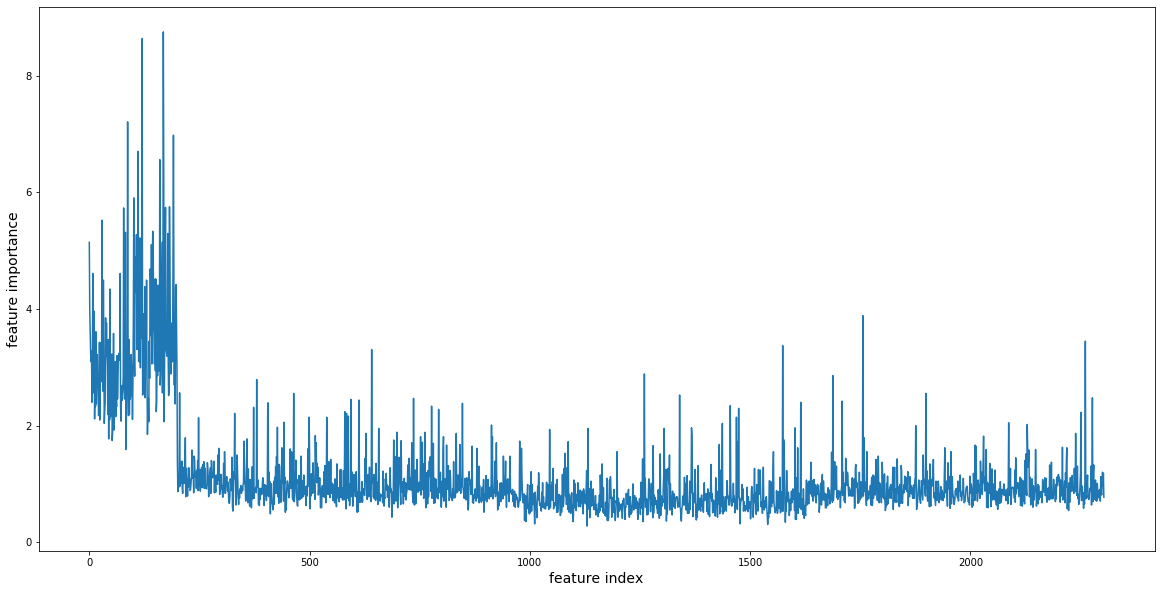

In [387]:
plt.figure(num=None, figsize=(20,10))
plt.plot(average_fis)
plt.xlabel('feature index', fontsize=14)
plt.ylabel('feature importance', fontsize=14)
plt.savefig('negishi_random_inputs_bm_fis.png', dpi=100)

In [388]:
plt.close()

## Classifier trellis method (CT)

In [429]:
def train_one_lgbm_classifier(X_train, y_train):
    """
    Trains one LightGBM binary classifier for a single bin in the label space.
    Differs from train_lgbm_classifier as is not wrapped in a
    OneVsRestClassifier and does not add single classifiers to joblib.
    Model parameters are otherwise identical
    
    ARGUMENTs:
        (pd.DataFrame)X_train: training set inputs as pandas dataframe
        (pd.DataFrame)y_train: training set outputs as pandas dataframe
        
    RETURNS:
        (LGBMClassifier)clf: fitted lightgbm model 
    """
    clf = LGBMClassifier(
        n_jobs=-1,
        max_depth=7,
        tree_method='gpu_hist',
        gpu_id=0,
        verbosity=2,
        eval_metric='aucpr'
    )
    clf.fit(X_train, y_train)
    return clf


class ClassifierTrellis:
    def __init__(self, struct, fit_func):
        self.struct = struct
        self.fit_func = fit_func
        self.width = len(struct)
        self.clfs = [[None for col in range(self.width)]
                     for row in range(self.width)]
    
    def create_X_trellis(self, X, Y, row, col):
        """
        Forms trellis structure at given position in grid with propagation
        directions from label dependency matrix
        
        ARGUMENTS:
            (pandas.DataFrame)X: input dataframe
            (pandas.DataFrame)Y: output dataframe
            (int)row: current row index
            (int)col: current column index
            
        RETURNS:
            (pandas.DataFrame)X_trellis: trellis structure at given position
            in grid
        """
        # Set empty label propagation matrix
        n_rows = len(X)
        dep_Y = pd.DataFrame({
            'topleft': np.zeros(n_rows),
            'left': np.zeros(n_rows),
            'top': np.zeros(n_rows)
        }, index=X.index)

        # Fill in dependency matrix with output labels in each applicable
        # propagation direction
        if row > 0:
            dep_Y['top'] = Y[self.struct[row - 1][col][1]]
        if col > 0:
            dep_Y['left'] = Y[self.struct[row][col - 1][1]]
        if row > 0 and col > 0:
            dep_Y['topleft'] = Y[self.struct[row - 1][col - 1][1]]
        
        # Append label values to input vectors
        X_trellis = X.merge(dep_Y, left_index=True, right_index=True)
        return X_trellis

    def fit(self, X, Y, train_on_predictions=False):
        """
        Fits a classifier for each label in the trellis
        
        ARGUMENTS:
            (pandas.DataFrame)X: input dataframe
            (pandas.DataFrame)Y: output dataframe
            (Bool)train_on_predictions: whether to append predicted or 
            ground truth labels as the propagated inputs in training
            
        RETURNS:
            self.clfs will be fit to training data
        """
        # Set empty dataframe to fill in predicted outputs
        preds_df = pd.DataFrame(index=X.index)
        
        # Iterate through the trellis updating inputs and fitting classifiers
        for row in range(self.width):
            for col in range(self.width):
                if self.struct[row][col] is None:
                    continue
                # Get current label bin to be predicted
                target_col = self.struct[row][col][1]
                if train_on_predictions:
                    # Use predictions to make trellis columns
                    X_trellis = self.create_X_trellis(X, preds_df, row, col)
                else:
                    # Use ground truth to make trellis columns
                    X_trellis = self.create_X_trellis(X, Y, row, col)
                #print("Training clf at ({}, {}) called: {}".format(row, col, target_col))
                # Train classifier for current label with updated inputs
                self.clfs[row][col] = self.fit_func(X_trellis, Y[target_col])

                # Update prediction set with outputs from current classifier
                if train_on_predictions:
                    # Create predictions for use in training
                    #print("Predicting clf at ({}, {}) called: {}".format(row, col, target_col))
                    col_preds = self.clfs[row][col].predict_proba(X_trellis)
                    preds_df[target_col] = col_preds[:,1]

        
    def predict(self, X):
        """
        Make predictions using trellis classifiers
        
        ARGUMENTS:
            (pandas.DataFrame)X: input dataframe
            
        RETURNS:
            (pandas.DataFrame)preds_df: predicted outputs for all examples in X
        """
        preds_df = pd.DataFrame(index=X.index)
        for row in range(self.width):
            for col in range(self.width):
                if self.struct[row][col] is None:
                    continue
                target_col = self.struct[row][col][1]
                X_trellis = self.create_X_trellis(X, preds_df, row, col)
                #print("Predicting clf at ({}, {}) called: {}".format(row, col, target_col))
                col_preds = self.clfs[row][col].predict_proba(X_trellis)
                preds_df[target_col] = col_preds[:,1]
        return preds_df
    
    def predict_on_zeros(self, X):
        """
        Make predictions using trellis classifiers removing propagated inputs

        ARGUMENTS:
            (pandas.DataFrame)X: input dataframe

        RETURNS:
            (pandas.DataFrame)preds_df: predicted outputs for all examples in X
        """
        preds_df = pd.DataFrame(index=X.index)
        for row in range(self.width):
            for col in range(self.width):
                if self.struct[row][col] is None:
                    continue
                target_col = self.struct[row][col][1]
                X_trellis = self.create_X_trellis(X, preds_df, row, col)
                #print("Predicting clf at ({}, {}) called: {}".format(row, col, target_col))
                col_preds = self.clfs[row][col].predict_proba(X_trellis)
                preds_df[target_col] = np.zeros(col_preds[:,1].shape)
        return preds_df

## Full CT model
### Trained on propagated predictions

In [428]:
# Construct classifier trellis
negishi_ct = ClassifierTrellis(struct, train_one_lgbm_classifier)

# Train CT model
start_time = time.time()
negishi_ct.fit(X_train, y_train, train_on_predictions=True)
print(f'Training complete. Training time: {time.time()-start_time} s')

# Save CT model
joblib.dump(negishi_ct, 'negishi_ct_gbms.model.joblib')

# Make predictions with trained model
ct_full_preds = negishi_ct.predict(X_test)

# Re-index to match dictionary order
ct_full_preds = ct_full_preds.reindex(y_test.columns, axis=1)

# Get top-k predicted rankings from prediction set
# Must use preds.values here as get dataframe not array from ct.predict
ct_full_preds_labeled = get_top_k_preds(
    ct_full_preds.values, cutoffs, category_initials, k=3, include_nulls=True
)

# Get labels from ground truth
y_test_labeled = label_ground_truth(
    y_test, cutoffs, category_initials, include_nulls=True
)

# Format results for performance metric calculations
type_count = get_type_count(cutoffs, category_initials)
ct_full_formatted_results = format_results_for_metrics(
    ct_full_preds_labeled, y_test_labeled, type_count, category_initials
)

# Calculate metrics and save results file
ct_full_metrics = get_metrics_dict(
    ct_full_formatted_results, type_count, 'ct_metrics.json'
)

# View top-1 and top-3 accuracy metrics
ct_full_top_1_acc = ct_full_metrics['top_1_acc']
ct_full_top_3_acc = ct_full_metrics['top_k_acc']

Training clf at (0, 0) called: reagent_0
Predicting clf at (0, 0) called: reagent_0
Training clf at (0, 1) called: null_ligands
Predicting clf at (0, 1) called: null_ligands
Training clf at (0, 2) called: reagent_1
Predicting clf at (0, 2) called: reagent_1
Training clf at (0, 3) called: reagent_32
Predicting clf at (0, 3) called: reagent_32
Training clf at (0, 4) called: reagent_63
Predicting clf at (0, 4) called: reagent_63
Training clf at (0, 5) called: null_additives
Predicting clf at (0, 5) called: null_additives
Training clf at (0, 6) called: reagent_62
Predicting clf at (0, 6) called: reagent_62
Training clf at (0, 7) called: reagent_64
Predicting clf at (0, 7) called: reagent_64
Training clf at (0, 8) called: null_metals
Predicting clf at (0, 8) called: null_metals
Training clf at (0, 9) called: reagent_100
Predicting clf at (0, 9) called: reagent_100
Training clf at (0, 10) called: null_other
Predicting clf at (0, 10) called: null_other
Training clf at (1, 0) called: reagent_5

### Control withholding predictions

In [430]:
# Make predictions with no propagated values
zero_input_ct_preds = negishi_ct.predict_on_zeros(X_test)

# Re-index to match dictionary order
zero_input_ct_preds = zero_input_ct_preds.reindex(y_test.columns, axis=1)

# Get top-k predicted rankings from prediction set
# Must use preds.values here as get dataframe not array from ct.predict
zero_input_ct_preds_labeled = get_top_k_preds(
    zero_input_ct_preds.values, cutoffs, category_initials, k=3, 
    include_nulls=True
)

# Get labels from ground truth
y_test_labeled = label_ground_truth(
    y_test, cutoffs, category_initials, include_nulls=True
)

# Format results for performance metric calculations
type_count = get_type_count(cutoffs, category_initials)
zero_input_ct_formatted_results = format_results_for_metrics(
    zero_input_ct_preds_labeled, y_test_labeled, type_count, category_initials
)

# Calculate metrics and save results file
zero_input_ct_metrics = get_metrics_dict(
    zero_input_ct_formatted_results, type_count, 'zero_input_ct_metrics.json'
)

# View top-1 and top-3 accuracy metrics
zero_input_ct_top_1_acc = zero_input_ct_metrics['top_1_acc']
zero_input_ct_top_3_acc = zero_input_ct_metrics['top_k_acc']

Predicting clf at (0, 0) called: reagent_0
Predicting clf at (0, 1) called: null_ligands
Predicting clf at (0, 2) called: reagent_1
Predicting clf at (0, 3) called: reagent_32
Predicting clf at (0, 4) called: reagent_63
Predicting clf at (0, 5) called: null_additives
Predicting clf at (0, 6) called: reagent_62
Predicting clf at (0, 7) called: reagent_64
Predicting clf at (0, 8) called: null_metals
Predicting clf at (0, 9) called: reagent_100
Predicting clf at (0, 10) called: null_other
Predicting clf at (1, 0) called: reagent_54
Predicting clf at (1, 1) called: reagent_8
Predicting clf at (1, 2) called: reagent_34
Predicting clf at (1, 3) called: reagent_52
Predicting clf at (1, 4) called: reagent_53
Predicting clf at (1, 5) called: reagent_99
Predicting clf at (1, 6) called: reagent_93
Predicting clf at (1, 7) called: reagent_95
Predicting clf at (1, 8) called: reagent_94
Predicting clf at (1, 9) called: null_solvents
Predicting clf at (1, 10) called: reagent_48
Predicting clf at (2, 

### Feature importances

In [461]:
all_fis = []

for i in range(len(negishi_ct.clfs)):
    for j in range(len(negishi_ct.clfs[i])):
        try:
            fis_ij = negishi_ct.clfs[i][j].feature_importances_
            smiles_fis_ij = fis_ij[:300].tolist()
            mordred_fis_ij = fis_ij[300:2304].tolist()
            reagent_fis_ij = fis_ij[2304:].tolist()
            avg_reagent_fis_ij = [(np.average(np.array(reagent_fis_ij)))]
            full_fis_ij = smiles_fis_ij + mordred_fis_ij + avg_reagent_fis_ij
            all_fis.append(full_fis_ij)
        except:
            continue
             
average_fis = np.average(np.array(all_fis), axis=0)
smiles_fis = average_fis[:300]
mordred_fis = average_fis[300:2304]
reagent_fis = average_fis[2304:]

sorted_fis = np.argsort(-average_fis)
sorted_smiles_fis = np.argsort(-smiles_fis)
sorted_mordred_fis = np.argsort(-mordred_fis)

#fi_names = X_train.columns[sorted_fis]
smiles_fi_names = X_train.columns[sorted_smiles_fis]
mordred_fi_names = X_train.columns[(sorted_mordred_fis+300)]

mordred_fi_df = pd.DataFrame(
    list(zip(mordred_fi_names, mordred_fis[sorted_mordred_fis])), 
    columns=['mordred_descriptor', 'fi_score']
)
mordred_fi_df.to_csv('negishi_ct_mordred_fis.csv')

top_fis = sorted_fis[:20]
top_smiles_fis = sorted_smiles_fis[:20]
top_mordred_fis = sorted_mordred_fis[:20]

#top_fi_names = fi_names[:20]
top_smiles_fi_names = smiles_fi_names[:20]
top_mordred_fi_names = mordred_fi_names[:20]

print(top_fis)
print(top_smiles_fi_names)
print(top_mordred_fi_names)

[2304  108  109  106  113  110    1   11  101  115    8    0    9  114
  111    4    3   14  100  102]
Index(['108', '109', '106', '113', '110', '1', '11', '101', '115', '8', '0',
       '9', '114', '111', '4', '3', '14', '100', '102', '107'],
      dtype='object')
Index(['rdfred_1_AATSC0i', 'product_JGI6', 'product_JGI3', 'product_JGI4',
       'product_SaasC', 'product_JGI5', 'rdfred_2_ATSC2dv', 'rdfred_1_bpol',
       'rdfred_1_ATSC5p', 'product_ATSC2dv', 'product_ATSC4i', 'product_JGI8',
       'rdfred_1_IC0', 'rdfred_1_ATSC5i', 'product_JGI7', 'rdfred_1_ATSC4p',
       'product_AATSC0i', 'rdfred_1_ATSC3dv', 'product_JGI2',
       'rdfred_2_ATSC1se'],
      dtype='object')


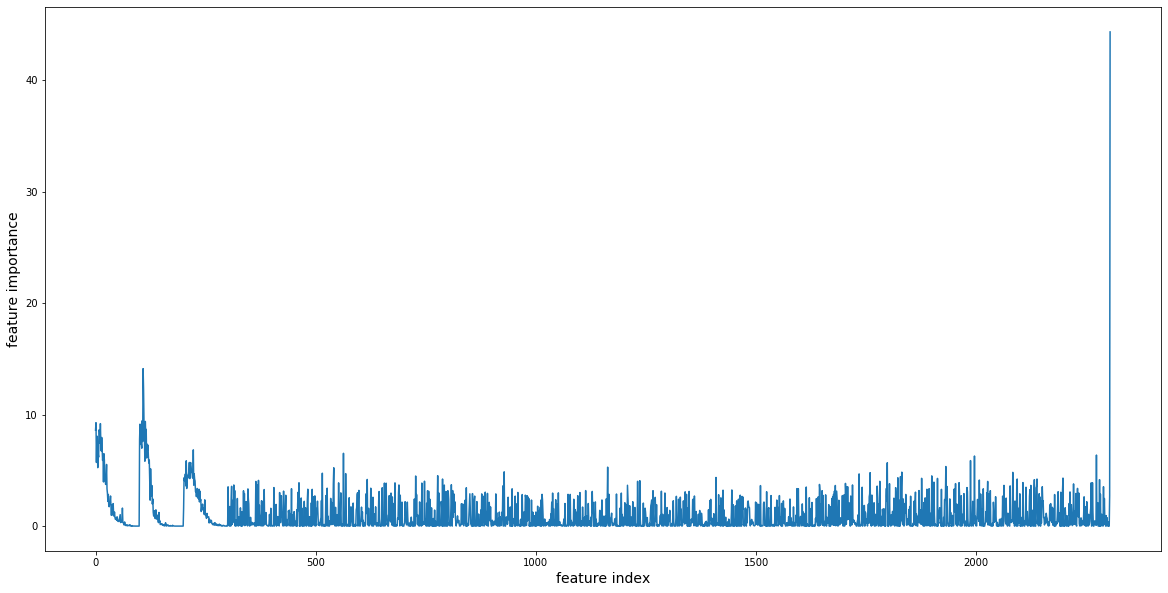

In [462]:
plt.figure(num=None, figsize=(20,10))
plt.plot(average_fis)
plt.xlabel('feature index', fontsize=14)
plt.ylabel('feature importance', fontsize=14)
plt.savefig('negishi_full_ct_fis.png', dpi=100)

In [463]:
plt.close()

## Dummy model

In [434]:
# Train model
start_time = time.time()
dummy_model_file = 'dummy_model.joblib'
dummy_clf = train_lgbm_classifier(
    np.zeros((len(y_train), 2)), y_train, dummy_model_file
)
print(f'Training complete. Training time: {time.time()-start_time} s')

# Make predictions with trained model
dummy_preds = dummy_clf.predict_proba(
    np.zeros((len(y_test), 2))
)

# Get top-k predicted rankings from prediction set
dummy_preds_labeled = get_top_k_preds(
    dummy_preds, cutoffs, category_initials, k=3, include_nulls=True
)

# Get labels from ground truth
y_test_labeled = label_ground_truth(
    y_test, cutoffs, category_initials, include_nulls=True
)

# Format results for performance metric calculations
type_count = get_type_count(cutoffs, category_initials)
dummy_formatted_results = format_results_for_metrics(
    dummy_preds_labeled, y_test_labeled, type_count, category_initials
)

# Calculate metrics and save results file
dummy_metrics = get_metrics_dict(
    dummy_formatted_results, type_count, 'dummy_metrics.json'
)

# View top-1 and top-3 accuracy metrics
dummy_top_1_acc = dummy_metrics['top_1_acc']
dummy_top_3_acc = dummy_metrics['top_k_acc']

/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 88 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 105 is present in all training examples.
  str(classes[c]))


Training complete. Training time: 2.1618642807006836 s
Top 1 accuracy for type  M  : 0.2827140549273021
Top 3 accuracy for type  M  : 0.4975767366720517
Top 1 accuracy for type  L  : 0.777059773828756
Top 3 accuracy for type  L  : 0.8352180936995154
Top 1 accuracy for type  S  : 0.6946688206785138
Top 3 accuracy for type  S  : 0.8820678513731826
Top 1 accuracy for type  A  : 0.8352180936995154
Top 3 accuracy for type  A  : 0.9079159935379645
Top 1 accuracy for type  T  : 0.3344103392568659
Top 3 accuracy for type  T  : 0.6009693053311793
Top 1 accuracy for type  O  : 0.8287560581583199
Top 3 accuracy for type  O  : 1.0
